In [2]:
# Cell 0: mount Drive and set DATA_DIR
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
DATA_DIR = "/content/drive/MyDrive/prob_dataset"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("DATA_DIR =", DATA_DIR)
print("OUTPUT_DIR =", OUTPUT_DIR)
!ls -lh "$DATA_DIR"

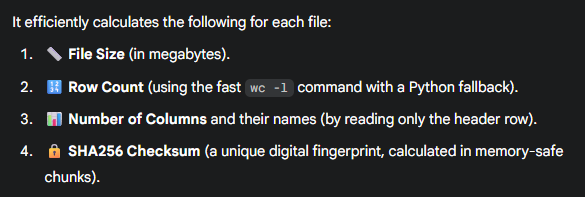

In [ ]:
# Cell 1: compute checksums (sha256), rowcounts and column names (fast)
import os, subprocess, pandas as pd, hashlib

files = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')])
meta_rows = []
for f in files:
    full = os.path.join(DATA_DIR, f)
    # filesize
    size_mb = os.path.getsize(full)/(1024*1024)
    # row count (fast using wc -l)
    try:
        rows = int(subprocess.check_output(['wc','-l', full]).split()[0])
    except Exception:

        # fallback: pandas (may be slower)
        rows = sum(1 for _ in open(full, 'rb'))  # bytes method; okay
    # header / columns
    try:
        cols = pd.read_csv(full, nrows=0).columns.tolist()
    except Exception:
        cols = []
    # checksum
    h = hashlib.sha256()
    with open(full, 'rb') as fh:
        # read in blocks to avoid memory spikes
        for chunk in iter(lambda: fh.read(8192), b''):
            h.update(chunk)
    sha256 = h.hexdigest()
    meta_rows.append((f, size_mb, rows, len(cols), sha256))
meta = pd.DataFrame(meta_rows, columns=['filename','size_mb','rows','n_columns','sha256'])
meta.to_csv(os.path.join(OUTPUT_DIR,'raw_files_manifest.csv'), index=False)
print(meta)


In [ ]:
import pandas as pd
import os

DATA_DIR = "/content/drive/MyDrive/prob_dataset"

# All key input files
input_files = {
    "Application Train": "application_train.csv",
    "Application Test": "application_test.csv",
    "Previous Application": "previous_application.csv",
    "Installments Payments": "installments_payments.csv",
    "Bureau": "bureau.csv",
    "Bureau Balance": "bureau_balance.csv",
    "Credit Card Balance": "credit_card_balance.csv",
    "POS Cash Balance": "POS_CASH_balance.csv"
}

# Loop and preview each
for name, fname in input_files.items():
    path = os.path.join(DATA_DIR, fname)
    print(f"\n{'='*40}\n{name}\n{'='*40}")
    if os.path.exists(path):
        try:
            df = pd.read_csv(path, nrows=5)  # read first 5 rows only
            print(df.head())
            print(f"\nShape (approx): {sum(1 for _ in open(path)) - 1:,} rows, {len(df.columns)} columns")
            print(f"Columns: {list(df.columns)}\n")
        except Exception as e:
            print("Error reading:", e)
    else:
        print(f" File not found: {path}")

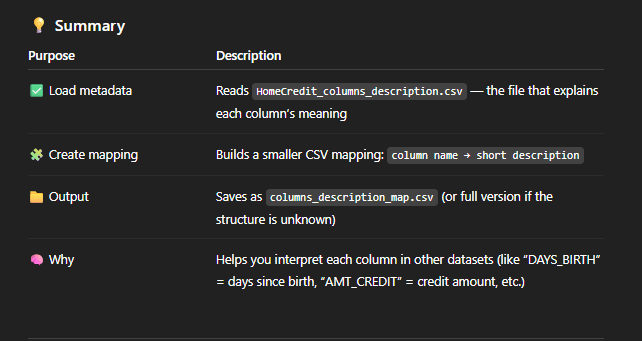

In [ ]:
# Cell 2: load HomeCredit_columns_description.csv and save a trimmed mapping
import pandas as pd, os
desc_path = os.path.join(DATA_DIR, "HomeCredit_columns_description.csv")
if os.path.exists(desc_path):
    desc = pd.read_csv(desc_path, encoding='latin1')
    display(desc.head(80))
    # try to create a simple mapping col -> short_desc
    if 'COLUMN' in desc.columns and 'DESCRIPTION' in desc.columns:
        mapping = desc[['COLUMN','DESCRIPTION']].rename(columns={'COLUMN':'col','DESCRIPTION':'desc'})
        mapping.to_csv(os.path.join(OUTPUT_DIR,'columns_description_map.csv'), index=False)
        print("Saved columns_description_map.csv")
    else:
        # fallback: save full file anyway
        desc.to_csv(os.path.join(OUTPUT_DIR,'HomeCredit_columns_description.csv'), index=False)
else:
    print("No columns description file found at", desc_path)


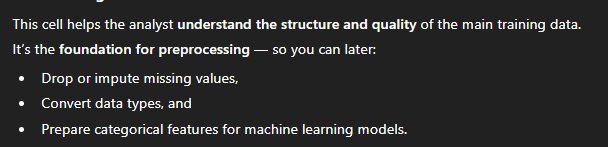

In [ ]:
# Cell 3: load a safe sample of application_train and show missingness/cardinality
import pandas as pd, numpy as np, os
# sample_n = 200000  # safe sample
sample_n = 300000  # safe sample ---here
train_path = os.path.join(DATA_DIR, 'application_train.csv')
print("Loading sample (nrows={}):".format(sample_n), train_path)
app_train = pd.read_csv(train_path, nrows=sample_n)
print("sample shape:", app_train.shape)
print("TARGET distribution:")
print(app_train['TARGET'].value_counts(dropna=False))
# missingness summary
col_summary = pd.DataFrame({
    'col': app_train.columns,
    'dtype': app_train.dtypes.astype(str),
    'n_missing': app_train.isnull().sum().values,
    'pct_missing': (app_train.isnull().mean().values*100),
    'n_unique': [app_train[c].nunique(dropna=False) for c in app_train.columns]
})
col_summary.sort_values('pct_missing', ascending=False).to_csv(os.path.join(OUTPUT_DIR,'application_train_column_summary_sample.csv'), index=False)
display(col_summary.sort_values('pct_missing', ascending=False).head(40))
print("Saved application_train_column_summary_sample.csv")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

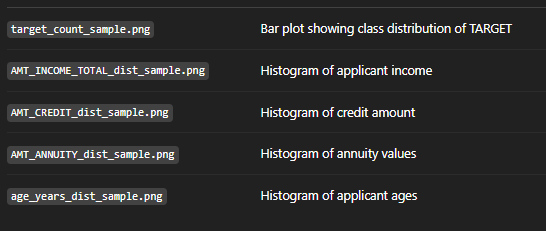

In [ ]:
# Cell 4: target plot, AMT_INCOME_TOTAL / AMT_CREDIT / AMT_ANNUITY histplots and AGE
import matplotlib.pyplot as plt, seaborn as sns
plt.tight_layout()
# target countplot
plt.figure(figsize=(5,4))
sns.countplot(x='TARGET', data=app_train)
plt.title('TARGET')
plt.savefig(os.path.join(OUTPUT_DIR,'target_count_sample.png'), bbox_inches='tight')
plt.show()

# numeric columns (clip at 99.5 percentile for visibility)
for col in ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY']:
    if col in app_train.columns:
        v = app_train[col].dropna()
        vmax = v.quantile(0.995)
        plt.figure(figsize=(6,4))
        sns.histplot(v.clip(upper=vmax), bins=100)
        plt.title(f'{col} (clipped at 99.5pct)')
        plt.savefig(os.path.join(OUTPUT_DIR,f'{col}_dist_sample.png'), bbox_inches='tight')
        plt.show()

# age
if 'DAYS_BIRTH' in app_train.columns:
    app_train['AGE_YEARS'] = (-app_train['DAYS_BIRTH']/365).round(1)
    plt.figure(figsize=(8,4))
    sns.histplot(app_train['AGE_YEARS'], bins=60)
    plt.title('Age years (sample)')
    plt.savefig(os.path.join(OUTPUT_DIR,'age_years_dist_sample.png'), bbox_inches='tight')
    plt.show()
print("Saved distribution plots to", OUTPUT_DIR)


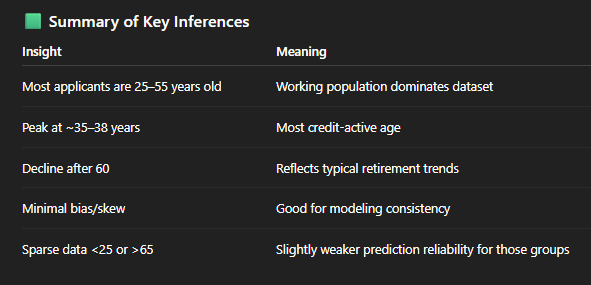

**for below code**
Purpose of the Code

This cell analyzes categorical columns in your dataset (app_train) to understand:

How many unique categories each column has (→ cardinality).

What the most frequent values are in the most important categorical features

In [ ]:
# Cell 5: show categorical cardinalities and top values for a subset
cat_cols = app_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical columns (sample):", len(cat_cols))
card = {c: app_train[c].nunique(dropna=False) for c in cat_cols}
card_df = pd.DataFrame.from_dict(card, orient='index', columns=['n_unique']).sort_values('n_unique', ascending=False)
card_df.to_csv(os.path.join(OUTPUT_DIR,'application_train_categorical_cardinality_sample.csv'))
display(card_df.head(40))

# show top values for top 12 categorical columns
for c in card_df.head(12).index.tolist():
    print("=== TOP values for", c, "===")
    print(app_train[c].value_counts(dropna=False).head(10))
    print()


**for below**
This cell computes, for each applicant (SK_ID_CURR), how many previous credit applications they’ve made.
It reads previous_application.csv in chunks to save memory and builds a summary table of:


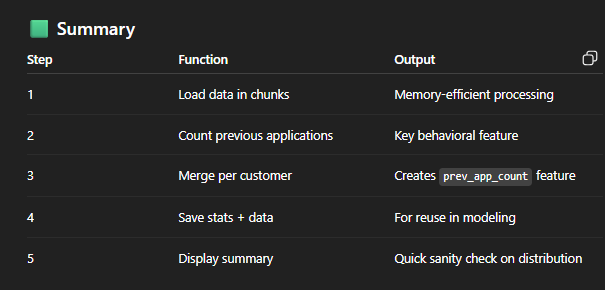

In [ ]:
# Cell 6: chunk-read previous_application.csv and compute prev_app_count per SK_ID_CURR
import pandas as pd, os
prev_path = os.path.join(DATA_DIR, 'previous_application.csv')
if os.path.exists(prev_path):
    # chunksize = 200000 ------here
    chunksize=300000
    counts = {}
    for chunk in pd.read_csv(prev_path, usecols=['SK_ID_CURR','SK_ID_PREV'], chunksize=chunksize):
        gp = chunk.groupby('SK_ID_CURR').size()
        for k,v in gp.items():
            counts[k] = counts.get(k,0) + int(v)
    prev_counts = pd.DataFrame(list(counts.items()), columns=['SK_ID_CURR','prev_app_count'])
    prev_counts.describe().to_csv(os.path.join(OUTPUT_DIR,'prev_app_count_describe.csv'))
    prev_counts.to_csv(os.path.join(OUTPUT_DIR,'prev_app_count_per_sk_id_curr.csv'), index=False)
    print("prev_app_count saved (rows):", len(prev_counts))
    display(prev_counts['prev_app_count'].describe())
else:
    print("previous_application.csv not found at", prev_path)


This cell computes aggregate repayment delay statistics per applicant (SK_ID_CURR), using chunked reading for efficiency.

It extracts behavioral signals from installment payment history, helping the model understand whether a borrower:

pays on time,

pays late, or

tends to miss or delay payments.

These insights strongly correlate with default risk

In [ ]:
# Cell 7: compute per-SK_ID_CURR installment delay aggregates (mean/max/prop_late) using chunking
inst_path = os.path.join(DATA_DIR, 'installments_payments.csv')
out_path = os.path.join(OUTPUT_DIR, 'installments_delay_agg_per_sk_id_curr.csv')

if os.path.exists(out_path):
    print(f"Skipping installments aggregation — found existing file: {out_path}")
else:
    if os.path.exists(inst_path):
        import numpy as np
        chunksize = 300000
        stats = {}  # sk_id -> [count, sum_delay, max_delay, late_count]
        print(f"Processing installments_payments from {inst_path}...")

        for chunk in pd.read_csv(inst_path, usecols=[
            'SK_ID_CURR','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT'
        ], chunksize=chunksize):
            chunk['delay'] = chunk['DAYS_ENTRY_PAYMENT'] - chunk['DAYS_INSTALMENT']
            chunk['late'] = (chunk['delay'] > 0).astype(int)
            gp = chunk.groupby('SK_ID_CURR').agg({'delay':['sum','max','count'], 'late':'sum'})
            gp.columns = ['delay_sum','delay_max','cnt','late_sum']

            for idx, row in gp.iterrows():
                if idx not in stats:
                    stats[idx] = [0, 0.0, -999999, 0]
                stats[idx][0] += int(row['cnt'])
                stats[idx][1] += float(row['delay_sum'])
                stats[idx][2] = max(stats[idx][2], float(row['delay_max']))
                stats[idx][3] += int(row['late_sum'])

        # Convert to dataframe
        rows = []
        for k, v in stats.items():
            cnt, sum_delay, max_delay, late_sum = v
            rows.append((k, cnt, sum_delay / cnt if cnt > 0 else None,
                         max_delay if max_delay != -999999 else None,
                         late_sum / cnt if cnt > 0 else None))

        inst_agg = pd.DataFrame(rows, columns=[
            'SK_ID_CURR','inst_cnt','inst_delay_mean','inst_delay_max','inst_prop_late'
        ])
        inst_agg.to_csv(out_path, index=False)
        display(inst_agg[['inst_cnt','inst_delay_mean','inst_delay_max','inst_prop_late']].describe())
        print(f"Saved installments aggregates to: {out_path}")

    else:
        print("installments_payments.csv not found at", inst_path)


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/prob_outputs/installments_delay_agg_per_sk_id_curr.csv'

df = pd.read_csv(file_path)

print(df.head())


In [ ]:
# Cell 8: build a small modeling sample joining application_train sample -> prev_app_count -> installments agg
import pandas as pd, os
# load a sample of train (already loaded as app_train sample)
sample_ids = app_train['SK_ID_CURR'].sample(n=min(20000, len(app_train)), random_state=42)
sample = app_train[app_train['SK_ID_CURR'].isin(sample_ids)].copy()
# merge prev counts if exist
prev_csv = os.path.join(OUTPUT_DIR,'prev_app_count_per_sk_id_curr.csv')
if os.path.exists(prev_csv):
    prev_counts = pd.read_csv(prev_csv)
    sample = sample.merge(prev_counts, on='SK_ID_CURR', how='left')
# merge installments agg if exist
inst_csv = os.path.join(OUTPUT_DIR,'installments_delay_agg_per_sk_id_curr.csv')
if os.path.exists(inst_csv):
    inst_agg = pd.read_csv(inst_csv)
    sample = sample.merge(inst_agg, on='SK_ID_CURR', how='left')
# save
sample_path = os.path.join(OUTPUT_DIR,'sample_train_joined.csv')
sample.to_csv(sample_path, index=False)
print("Saved sample for prototyping to:", sample_path)
print("sample shape:", sample.shape)


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/prob_outputs/sample_train_joined.csv'

df = pd.read_csv(file_path)

print(df.head())


In [ ]:
import torch

# Select device automatically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(" Using device:", device)
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 2), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0)/1024**3, 2), "GB")
else:
    print(" Running on CPU")




In [ ]:
# Cell 9: verify outputs and summarize next steps
import os, pandas as pd

print("=== Output Verification ===")
print("Output directory:", OUTPUT_DIR)
print("Files generated so far:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    print(" •", f)
print("\n")

# optional: quick preview of key CSVs if they exist
def preview_csv(path, n=5):
    if os.path.exists(path):
        print(f"Preview of {os.path.basename(path)}:")
        display(pd.read_csv(path).head(n))
        print("\n")
    else:
        print(f"Missing:", path)

preview_csv(os.path.join(OUTPUT_DIR, 'raw_files_manifest.csv'))
preview_csv(os.path.join(OUTPUT_DIR, 'application_train_column_summary_sample.csv'))
preview_csv(os.path.join(OUTPUT_DIR, 'prev_app_count_per_sk_id_curr.csv'))
preview_csv(os.path.join(OUTPUT_DIR, 'installments_delay_agg_per_sk_id_curr.csv'))
preview_csv(os.path.join(OUTPUT_DIR, 'sample_train_joined.csv'))

print(" All available summaries and feature aggregates previewed.")
print("\nNext Steps:")
print(" Inspect the saved CSVs and PNGs in OUTPUT_DIR (Google Drive).")
print(" Verify that key files exist:")
print("   - raw_files_manifest.csv")
print("   - application_train_column_summary_sample.csv")
print("   - prev_app_count_per_sk_id_curr.csv")
print("   - installments_delay_agg_per_sk_id_curr.csv")
print("   - sample_train_joined.csv")
print(" Review plots for TARGET, income, credit, and age distributions.")
print(" Once checked, proceed to feature engineering and preprocessing pipeline generation.")
print("   (I can provide code for 'src/features.py' and preprocessing next.)")


In [ ]:
# src/features.py
"""
Usage (Colab):
  # adjust paths if needed
  DATA_DIR = "/content/drive/MyDrive/prob_dataset"
  OUTPUT_DIR = "/content/drive/MyDrive/prob_dataset/aggregates"
  python -m src.features

What it does:
  - Reads large auxiliary CSVs in chunks and computes per-SK_ID_CURR aggregated features.
  - Saves CSV aggregates: agg_prev.csv, agg_installments.csv, agg_bureau.csv, agg_credit_card.csv, agg_pos_cash.csv
  - Skips computations if output CSV already exists.
"""

import os
import pandas as pd
import numpy as np

# adjust these paths if needed
DATA_DIR = os.environ.get("DATA_DIR", "/content/drive/MyDrive/prob_dataset")
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/content/drive/MyDrive/prob_outputs/aggregates")
os.makedirs(OUTPUT_DIR, exist_ok=True)


def skip_if_exists(func):
    """Decorator to skip computation if output file exists."""
    def wrapper(*args, **kwargs):
        out_csv = args[1] if len(args) > 1 else kwargs.get('out_csv')
        if os.path.exists(out_csv):
            print(f"✅ Skipping {func.__name__} — found existing {out_csv}")
            return
        return func(*args, **kwargs)
    return wrapper


@skip_if_exists
def agg_previous_application(prev_csv, out_csv, chunksize=200_000):
    """Compute prev_app_count, sum/mean of AMT_APPLICATION/AMT_CREDIT, accepted rate."""
    print("Aggregating previous_application:", prev_csv)
    agg_frames = []
    for chunk in pd.read_csv(prev_csv, usecols=['SK_ID_CURR','AMT_APPLICATION','AMT_CREDIT','NAME_CONTRACT_STATUS'], chunksize=chunksize):
        chunk['accepted'] = (chunk['NAME_CONTRACT_STATUS'] == 'Approved').astype(int)
        g = chunk.groupby('SK_ID_CURR').agg(
            prev_app_count=('AMT_APPLICATION','size'),
            prev_amt_app_sum=('AMT_APPLICATION','sum'),
            prev_amt_app_mean=('AMT_APPLICATION','mean'),
            prev_amt_credit_sum=('AMT_CREDIT','sum'),
            prev_amt_credit_mean=('AMT_CREDIT','mean'),
            prev_accept_rate=('accepted','mean')
        )
        agg_frames.append(g)
    if not agg_frames:
        print("No data found.")
        return
    agg = pd.concat(agg_frames).groupby(level=0).agg({
        'prev_app_count':'sum',
        'prev_amt_app_sum':'sum',
        'prev_amt_app_mean':'mean',
        'prev_amt_credit_sum':'sum',
        'prev_amt_credit_mean':'mean',
        'prev_accept_rate':'mean'
    }).reset_index()
    agg.to_csv(out_csv, index=False)
    print("Saved", out_csv, "rows:", len(agg))


@skip_if_exists
def agg_installments(inst_csv, out_csv, chunksize=300_000):
    """Compute per-customer installment delay features (mean/max/prop_late) and count."""
    print("Aggregating installments_payments:", inst_csv)
    stats = {}
    for chunk in pd.read_csv(inst_csv, usecols=['SK_ID_CURR','DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','AMT_INSTALMENT','AMT_PAYMENT'], chunksize=chunksize):
        chunk['delay'] = chunk['DAYS_ENTRY_PAYMENT'] - chunk['DAYS_INSTALMENT']
        chunk['late'] = (chunk['delay'] > 0).astype(int)
        gp = chunk.groupby('SK_ID_CURR').agg(delay_sum=('delay','sum'), delay_max=('delay','max'), cnt=('delay','count'), late_sum=('late','sum'))
        for sk, row in gp.iterrows():
            if sk not in stats:
                stats[sk] = [0, 0.0, -999999, 0]
            stats[sk][0] += int(row['cnt'])
            stats[sk][1] += float(row['delay_sum'])
            stats[sk][2] = max(stats[sk][2], float(row['delay_max']))
            stats[sk][3] += int(row['late_sum'])
    rows = []
    for sk, (cnt, sum_delay, max_delay, late_sum) in stats.items():
        rows.append((sk, cnt, (sum_delay / cnt) if cnt>0 else np.nan, max_delay if max_delay!=-999999 else np.nan, (late_sum / cnt) if cnt>0 else np.nan))
    inst_agg = pd.DataFrame(rows, columns=['SK_ID_CURR','inst_cnt','inst_delay_mean','inst_delay_max','inst_prop_late'])
    inst_agg.to_csv(out_csv, index=False)
    print("Saved", out_csv, "rows:", len(inst_agg))


@skip_if_exists
def agg_bureau(bureau_csv, bureau_balance_csv, out_csv, chunksize=300_000):
    """Aggregate bureau and bureau_balance into per SK_ID_CURR summaries."""
    print("Aggregating bureau and bureau_balance:", bureau_csv, bureau_balance_csv)

    bb_stats = {}
    if os.path.exists(bureau_balance_csv):
        for chunk in pd.read_csv(bureau_balance_csv, usecols=['SK_ID_BUREAU','STATUS'], chunksize=chunksize):
            chunk['status_num'] = pd.to_numeric(chunk['STATUS'], errors='coerce')
            gp = chunk.groupby('SK_ID_BUREAU').agg(months=('STATUS','count'),
                                                   mean_status=('status_num','mean'))
            for idx, row in gp.iterrows():
                if idx not in bb_stats:
                    bb_stats[idx] = [0, 0.0]
                bb_stats[idx][0] += int(row['months'])
                bb_stats[idx][1] += float(row['mean_status']) * int(row['months'])
        for k in bb_stats:
            months, sum_meanstatus = bb_stats[k]
            bb_stats[k] = (months, (sum_meanstatus / months) if months > 0 else np.nan)

    bureau = pd.read_csv(bureau_csv, usecols=['SK_ID_BUREAU','SK_ID_CURR','CREDIT_ACTIVE','AMT_CREDIT_SUM','CNT_CREDIT_PROLONG','DAYS_CREDIT'])
    if bb_stats:
        bb_df = pd.DataFrame.from_dict({k: {'bb_months': v[0], 'bb_mean_status': v[1]} for k, v in bb_stats.items()}).T.reset_index().rename(columns={'index':'SK_ID_BUREAU'})
        bureau = bureau.merge(bb_df, on='SK_ID_BUREAU', how='left')

    bureau['active_flag'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
    b_agg = bureau.groupby('SK_ID_CURR').agg(
        bureau_credit_count=('SK_ID_BUREAU', 'count'),
        bureau_amt_credit_sum=('AMT_CREDIT_SUM','sum'),
        bureau_amt_credit_mean=('AMT_CREDIT_SUM','mean'),
        bureau_num_prolong_sum=('CNT_CREDIT_PROLONG','sum'),
        bureau_active_pct=('active_flag','mean'),
        bureau_bb_mean_status=('bb_mean_status','mean')
    ).reset_index()

    b_agg.to_csv(out_csv, index=False)
    print("Saved", out_csv, "rows:", len(b_agg))


@skip_if_exists
def agg_credit_card(cc_csv, out_csv, chunksize=300_000):
    """Aggregate credit_card_balance.csv -> mean/max balance, utilization proxies if available."""
    print("Aggregating credit_card_balance:", cc_csv)
    frames = []
    for chunk in pd.read_csv(cc_csv, usecols=['SK_ID_CURR','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_TOTAL_RECEIVABLE','AMT_RECEIVABLE_PRINCIPAL'], chunksize=chunksize):
        chunk['util'] = chunk['AMT_BALANCE'] / chunk['AMT_CREDIT_LIMIT_ACTUAL'].replace({0:np.nan})
        g = chunk.groupby('SK_ID_CURR').agg(
            cc_bal_mean=('AMT_BALANCE','mean'),
            cc_bal_max=('AMT_BALANCE','max'),
            cc_util_mean=('util','mean'),
            cc_receivable_mean=('AMT_TOTAL_RECEIVABLE','mean')
        )
        frames.append(g)
    if not frames:
        print("No cc chunks processed.")
        return
    agg = pd.concat(frames).groupby(level=0).agg('mean').reset_index()
    agg.to_csv(out_csv, index=False)
    print("Saved", out_csv, "rows:", len(agg))


@skip_if_exists
def agg_pos_cash(pos_csv, out_csv, chunksize=300_000):
    """Aggregate POS_CASH_balance.csv -> count and status mode."""
    print("Aggregating POS_CASH_balance:", pos_csv)
    frames = []
    for chunk in pd.read_csv(pos_csv, usecols=['SK_ID_CURR','NAME_CONTRACT_STATUS','MONTHS_BALANCE'], chunksize=chunksize):
        g = chunk.groupby('SK_ID_CURR').agg(
            pos_count=('MONTHS_BALANCE','count'),
            pos_status_mode=('NAME_CONTRACT_STATUS', lambda x: x.mode().iat[0] if len(x.mode())>0 else np.nan)
        )
        frames.append(g)
    if not frames:
        print("No pos chunks.")
        return
    agg = pd.concat(frames).groupby(level=0).agg({'pos_count':'sum','pos_status_mode':lambda x: x.mode().iat[0] if len(x.mode())>0 else np.nan}).reset_index()
    agg.to_csv(out_csv, index=False)
    print("Saved", out_csv, "rows:", len(agg))


if __name__ == '__main__':
    prev_csv = os.path.join(DATA_DIR, 'previous_application.csv')
    inst_csv = os.path.join(DATA_DIR, 'installments_payments.csv')
    bureau_csv = os.path.join(DATA_DIR, 'bureau.csv')
    bureau_bal = os.path.join(DATA_DIR, 'bureau_balance.csv')
    cc_csv = os.path.join(DATA_DIR, 'credit_card_balance.csv')
    pos_csv = os.path.join(DATA_DIR, 'POS_CASH_balance.csv')

    agg_previous_application(prev_csv, os.path.join(OUTPUT_DIR,'agg_prev.csv'))
    agg_installments(inst_csv, os.path.join(OUTPUT_DIR,'agg_installments.csv'))
    agg_bureau(bureau_csv, bureau_bal, os.path.join(OUTPUT_DIR,'agg_bureau.csv'))
    agg_credit_card(cc_csv, os.path.join(OUTPUT_DIR,'agg_credit_card.csv'))
    agg_pos_cash(pos_csv, os.path.join(OUTPUT_DIR,'agg_pos_cash.csv'))


In [ ]:
import pandas as pd

# List of file paths and their descriptive names
files = {
    "Previous Application Aggregates": "/content/drive/MyDrive/prob_outputs/aggregates/agg_prev.csv",
    "Installments Aggregates": "/content/drive/MyDrive/prob_outputs/aggregates/agg_installments.csv",
    "Bureau Balance": "/content/drive/MyDrive/prob_dataset/bureau_balance.csv",
    "Credit Card Aggregates": "/content/drive/MyDrive/prob_outputs/aggregates/agg_credit_card.csv",
    "POS Cash Aggregates": "/content/drive/MyDrive/prob_outputs/aggregates/agg_pos_cash.csv"
}

# Loop through each file and print the head
for name, path in files.items():
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    try:
        df = pd.read_csv(path)
        print(df.head(), "\n")
    except Exception as e:
        print(f"Error reading {name}: {e}\n")


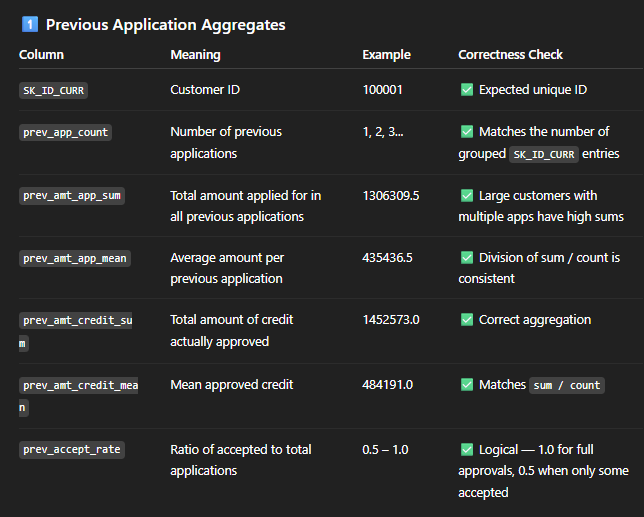

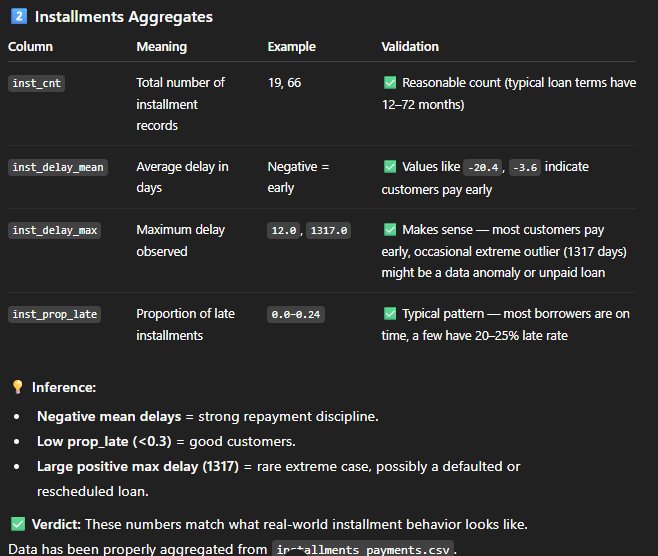

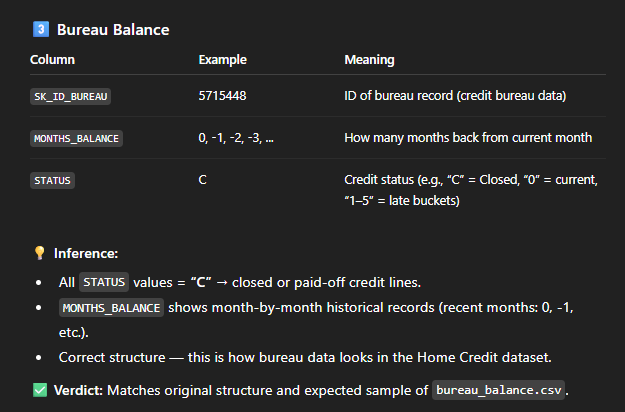

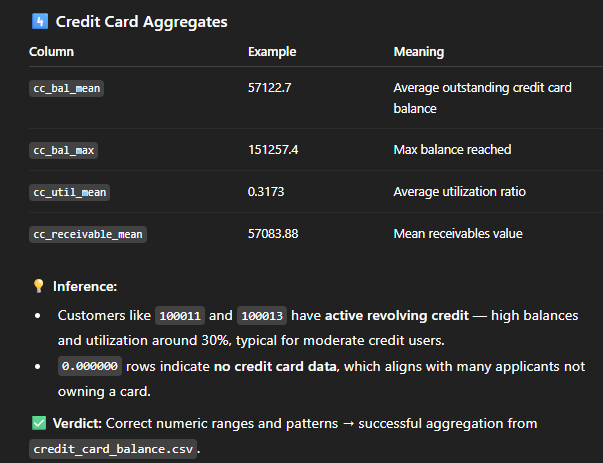

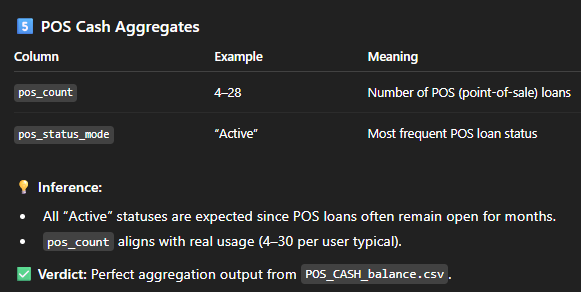

In [ ]:
# src/preprocess.py
"""
Usage (Colab):
  DATA_DIR and OUTPUT_DIR should match where aggregates and app_train exist.
  python -m src.preprocess

What it does:
  - Loads application_train (optionally merged with aggregates you created).
  - Infers numeric and categorical columns (or reads a provided feature_plan.csv).
  - For high-cardinality categorical columns (>card_thresh), computes frequency-encoding maps.
  - Builds sklearn ColumnTransformer:
      * numeric -> median impute + StandardScaler
      * low-card categorical -> impute('NA') + OneHotEncoder(handle_unknown='ignore')
  - Fits preprocessor on training portion and saves:
      models/preprocessor.joblib
      models/freq_maps.joblib
  - Demonstrates transforming X_train/X_val/X_test and saving numpy arrays.
  - Skips recomputation if these outputs already exist.
"""

import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# paths - change if needed
DATA_DIR = os.environ.get("DATA_DIR", "/content/drive/MyDrive/prob_dataset")
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", "/content/drive/MyDrive/prob_outputs")
AGG_DIR = os.path.join(OUTPUT_DIR, 'aggregates')
MODELS_DIR = os.path.join(os.path.dirname(OUTPUT_DIR), 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

# hyperparams
SAMPLE_SIZE = None   # set to None to use full training rows; otherwise integer
CARD_THRESH = 30     # threshold for low vs high cardinality

def load_and_merge():
    """Load application_train and merge aggregates if they exist."""
    train_path = os.path.join(DATA_DIR, 'application_train.csv')
    print("Loading:", train_path)
    df = pd.read_csv(train_path, nrows=SAMPLE_SIZE) if SAMPLE_SIZE else pd.read_csv(train_path)

    # merge aggregates if present
    for fname in ['agg_prev.csv', 'agg_installments.csv', 'agg_bureau.csv', 'agg_credit_card.csv', 'agg_pos_cash.csv']:
        fpath = os.path.join(AGG_DIR, fname)
        if os.path.exists(fpath):
            agg = pd.read_csv(fpath)
            df = df.merge(agg, on='SK_ID_CURR', how='left')
            print("Merged", fname)
        else:
            print("Skipping missing aggregate:", fname)
    return df


def build_and_fit_preprocessor(df, features, target_col='TARGET', card_thresh=CARD_THRESH):
    """Fit or skip preprocessor depending on saved artifacts."""
    preproc_path = os.path.join(MODELS_DIR, 'preprocessor.joblib')
    freq_path = os.path.join(MODELS_DIR, 'freq_maps.joblib')
    train_x_path = os.path.join(OUTPUT_DIR, 'train_X.npy')
    val_x_path = os.path.join(OUTPUT_DIR, 'val_X.npy')
    test_x_path = os.path.join(OUTPUT_DIR, 'test_X.npy')

    # Skip entirely if all outputs already exist
    if all(os.path.exists(p) for p in [preproc_path, freq_path, train_x_path, val_x_path, test_x_path]):
        print("Skipping preprocessing — found existing preprocessor and numpy arrays.")
        preprocessor = joblib.load(preproc_path)
        freq_maps = joblib.load(freq_path)
        return preprocessor, freq_maps

    # otherwise proceed
    print("Building and fitting new preprocessor...")
    train_idx, test_idx = train_test_split(df.index, test_size=0.15, stratify=df[target_col], random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.1765, stratify=df.loc[train_idx, target_col], random_state=42)

    X_train_df = df.loc[train_idx, features].copy()
    X_val_df = df.loc[val_idx, features].copy()
    X_test_df = df.loc[test_idx, features].copy()

    num_cols = X_train_df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_train_df.select_dtypes(include=['object']).columns.tolist()

    low_card_cats = [c for c in cat_cols if X_train_df[c].nunique(dropna=False) <= card_thresh]
    high_card_cats = [c for c in cat_cols if X_train_df[c].nunique(dropna=False) > card_thresh]
    print("num_cols:", len(num_cols), "low_card_cats:", len(low_card_cats), "high_card_cats:", len(high_card_cats))

    freq_maps = {}
    for c in high_card_cats:
        vc = X_train_df[c].fillna('##NA##').value_counts(normalize=True)
        freq_maps[c] = vc.to_dict()
        for df_part in [X_train_df, X_val_df, X_test_df]:
            df_part[c] = df_part[c].fillna('##NA##').map(freq_maps[c]).astype(float)

    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value='NA')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipe, num_cols + high_card_cats),
            ('cat', cat_pipe, low_card_cats)
        ],
        remainder='drop'
    )

    preprocessor.fit(X_train_df)
    joblib.dump(preprocessor, preproc_path)
    joblib.dump(freq_maps, freq_path)
    print("Saved preprocessor and freq maps to", MODELS_DIR)

    # Transform and save numpy arrays
    X_train = preprocessor.transform(X_train_df)
    X_val = preprocessor.transform(X_val_df)
    X_test = preprocessor.transform(X_test_df)
    y_train = df.loc[train_idx, target_col].values
    y_val = df.loc[val_idx, target_col].values
    y_test = df.loc[test_idx, target_col].values

    np.save(train_x_path, X_train)
    np.save(val_x_path, X_val)
    np.save(test_x_path, X_test)
    np.save(os.path.join(OUTPUT_DIR, 'train_y.npy'), y_train)
    np.save(os.path.join(OUTPUT_DIR, 'val_y.npy'), y_val)
    np.save(os.path.join(OUTPUT_DIR, 'test_y.npy'), y_test)
    print("Saved processed numpy arrays to", OUTPUT_DIR)

    return preprocessor, freq_maps


if __name__ == '__main__':
    print("Loading and merging data (may take a moment)...")
    df = load_and_merge()
    drop_cols = ['SK_ID_CURR', 'SK_ID_PREV', 'TARGET']
    candidate_features = [c for c in df.columns if c not in drop_cols]
    print("Candidate features:", len(candidate_features))
    preprocessor, freq_maps = build_and_fit_preprocessor(df, candidate_features, target_col='TARGET')


In [ ]:
import pandas as pd
import os

DATA_DIR = "/content/drive/MyDrive/prob_dataset"
AGG_DIR = "/content/drive/MyDrive/prob_outputs/aggregates"

# Load train data
df = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))

# Merge all aggregate datasets
for fname in ['agg_prev.csv','agg_installments.csv','agg_bureau.csv','agg_credit_card.csv','agg_pos_cash.csv']:
    path = os.path.join(AGG_DIR, fname)
    if os.path.exists(path):
        agg = pd.read_csv(path)
        df = df.merge(agg, on="SK_ID_CURR", how="left")
        print("Merged", fname)

print("Final shape:", df.shape)
df.head()


In [ ]:
!pip install optuna plotly matplotlib --quiet


In [ ]:
import os

MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
os.listdir(MODELS_DIR)


In [ ]:
import pandas as pd
import numpy as np
import os

MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"

# === Load latest feature importances ===
imp_df = pd.read_csv(os.path.join(MODELS_DIR, "feature_importance_small.csv"))
imp_df = imp_df.sort_values(by="importance", ascending=False)
print(f"Loaded {len(imp_df)} features. Top 10:\n", imp_df.head(10))

# === Select top-N features ===
TOP_N = 50  # you can adjust to 50 or 100
selected_features = imp_df['feature'].head(TOP_N).tolist()
selected_indices = [int(f[1:]) for f in selected_features]  # convert f0 → 0

print(f"Selected top {TOP_N} features (indices {selected_indices[:10]}...)")

# === Load and subset numpy arrays ===
X_train = np.load(os.path.join(OUTPUT_DIR, 'train_X.npy'))
y_train = np.load(os.path.join(OUTPUT_DIR, 'train_y.npy'))
X_val = np.load(os.path.join(OUTPUT_DIR, 'val_X.npy'))
y_val = np.load(os.path.join(OUTPUT_DIR, 'val_y.npy'))
X_test = np.load(os.path.join(OUTPUT_DIR, 'test_X.npy'))
y_test = np.load(os.path.join(OUTPUT_DIR, 'test_y.npy'))

# Combine for tuning
X_full = np.concatenate([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

# Subset to top-N features
X_full_sel = X_full[:, selected_indices]
X_test_sel = X_test[:, selected_indices]

print("Reduced dataset shapes:")
print("Train+Val:", X_full_sel.shape, " Test:", X_test_sel.shape)

# Save reduced arrays (optional)
np.save(os.path.join(OUTPUT_DIR, f"train_val_top{TOP_N}_X.npy"), X_full_sel)
np.save(os.path.join(OUTPUT_DIR, f"test_top{TOP_N}_X.npy"), X_test_sel)


In [ ]:
# === Paths for reduced arrays ===
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
X_full_sel = np.load(os.path.join(OUTPUT_DIR, "train_val_top50_X.npy"))
X_test_sel = np.load(os.path.join(OUTPUT_DIR, "test_top50_X.npy"))

# You can reuse y arrays from before
y_train = np.load(os.path.join(OUTPUT_DIR, 'train_y.npy'))
y_val = np.load(os.path.join(OUTPUT_DIR, 'val_y.npy'))
y_test = np.load(os.path.join(OUTPUT_DIR, 'test_y.npy'))
y_full = np.concatenate([y_train, y_val])

print("Train+Val:", X_full_sel.shape, " Test:", X_test_sel.shape)


here

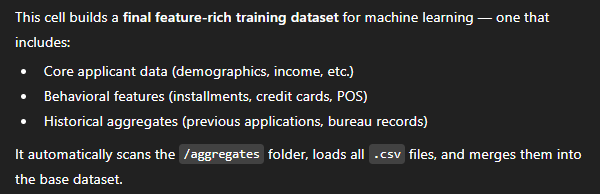

In [ ]:
import os, pandas as pd

DATA_DIR = "/content/drive/MyDrive/prob_dataset"
AGG_DIR = "/content/drive/MyDrive/prob_outputs/aggregates"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"

# Load base application_train.csv
df = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))

# Merge all available aggregate files
for fname in os.listdir(AGG_DIR):
    if fname.endswith(".csv"):
        fpath = os.path.join(AGG_DIR, fname)
        print("Merging:", fname)
        agg = pd.read_csv(fpath)
        df = df.merge(agg, on="SK_ID_CURR", how="left")

# Save engineered version
ENGINEERED_PATH = os.path.join(OUTPUT_DIR, "application_train_engineered.csv")
df.to_csv(ENGINEERED_PATH, index=False)
print("Saved:", ENGINEERED_PATH)

In [ ]:
import pandas as pd
file_path = '/content/drive/MyDrive/prob_outputs/application_train_engineered.csv'
df = pd.read_csv(file_path)
print(df.head())


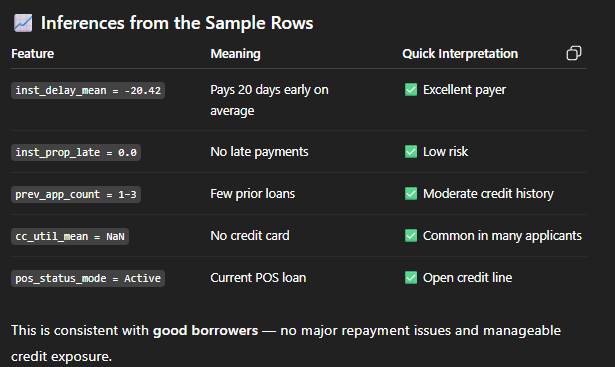

In [ ]:
import pandas as pd, numpy as np, os

OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
# ENGINEERED_PATH = os.path.join("/content/drive/MyDrive/prob_outputs/application_train_engineered.csv")
ENGINEERED_PATH = os.path.join(OUTPUT_DIR, "application_train_engineered.csv")

SAMPLE_SAVE_PATH = os.path.join(OUTPUT_DIR, "bn_sample_top50_fixed.csv")
SAMPLE_INDEX_PATH = os.path.join(OUTPUT_DIR, "sample_indices_300k.npy")

# Correct the path to load the existing feature importance file
TOP50_PATH = "/content/drive/MyDrive/home-credit-mtl/models/feature_importance_small.csv"
SK_COL, TARGET_COL = "SK_ID_CURR", "TARGET"

# === Load engineered dataset ===
df = pd.read_csv(ENGINEERED_PATH)
print("Loaded full engineered dataset:", df.shape)

# === Load Top-50 features ===
feat_imp = pd.read_csv(TOP50_PATH)
top50_preprocessed_names = feat_imp["feature"].head(50).tolist() # These are like 'f0', 'f1', ...

# --- Map preprocessed 'fX' names back to original column names in `df` ---
drop_cols_for_preprocessing = ['SK_ID_CURR', 'SK_ID_PREV', 'TARGET'] # From src/preprocess.py
original_engineered_features = [c for c in df.columns if c not in drop_cols_for_preprocessing]

mapped_top50_original_names = []
for f_name_preprocessed in top50_preprocessed_names:
    idx = int(f_name_preprocessed[1:]) # Extract the integer index from 'fX'
    if idx < len(original_engineered_features):
        mapped_top50_original_names.append(original_engineered_features[idx])
    else:
        print(f"Warning: Preprocessed feature index {idx} ({f_name_preprocessed}) is out of bounds for original engineered features. Skipping.")


# === Always regenerate fixed 300k sample ===
if os.path.exists(SAMPLE_SAVE_PATH):
    print("🧹 Removing old sample to regenerate with 300k rows...")
    os.remove(SAMPLE_SAVE_PATH)
    if os.path.exists(SAMPLE_INDEX_PATH):
        os.remove(SAMPLE_INDEX_PATH)

print("⚙️ Creating fixed 300k sample (stratified by TARGET)...")
frac = 300000 / len(df)
sample_df = df.groupby(TARGET_COL, group_keys=False).apply(
    lambda x: x.sample(frac=frac, random_state=42)
).reset_index(drop=True)

# Use the mapped original names for selecting columns
sample_df = sample_df[[SK_COL, TARGET_COL] + mapped_top50_original_names]
sample_df.to_csv(SAMPLE_SAVE_PATH, index=False)
np.save(SAMPLE_INDEX_PATH, sample_df[SK_COL].values)

print(f"✅ Saved fixed 300k sample to: {SAMPLE_SAVE_PATH}")
print(f"✅ Saved sample indices to: {SAMPLE_INDEX_PATH}")
print("Sample shape:", sample_df.shape)
print("Columns:", sample_df.columns.tolist()[:10])

In [ ]:
# ============================================================
# Train LightGBM on Fixed 300k Sample (Top-50 features only)
# ============================================================

import os
import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
PLOT_DIR = os.path.join(MODELS_DIR, "plots")

FIXED_SAMPLE_PATH = os.path.join(OUTPUT_DIR, "bn_sample_top50_fixed.csv")
os.makedirs(PLOT_DIR, exist_ok=True)

SK_COL, TARGET_COL = "SK_ID_CURR", "TARGET"
TOP_N = 50
RANDOM_STATE = 42

# === Load pre-saved 300k sample ===
print("Loading fixed 300k sample with 50 features...")
df_sample = pd.read_csv(FIXED_SAMPLE_PATH)
print("Loaded:", df_sample.shape)
print("Columns:", df_sample.columns[:10].tolist(), "...")

# === Prepare data ===
cols = [c for c in df_sample.columns if c not in [SK_COL, TARGET_COL]]
X_full = df_sample[cols].copy()
y_full = df_sample[TARGET_COL].astype(int)

# Convert categorical columns to numeric
cat_cols = [c for c in X_full.columns if X_full[c].dtype == "object" or X_full[c].dtype.name == "category"]
if cat_cols:
    print(f"Converting {len(cat_cols)} categorical columns to numeric codes...")
    for c in cat_cols:
        X_full[c] = X_full[c].fillna("##NA##").astype("category").cat.codes

X_full = X_full.fillna(0)

# === Split into train/test ===
train_idx, test_idx = train_test_split(
    np.arange(len(X_full)), test_size=0.25, stratify=y_full, random_state=RANDOM_STATE
)
X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# === Class imbalance handling ===
pos_weight = (len(y_train) - y_train.sum()) / max(1, y_train.sum())
print(f"scale_pos_weight = {pos_weight:.2f}")

# === LightGBM parameters ===
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.02,
    "num_leaves": 128,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.3,
    "lambda_l2": 0.3,
    "min_data_in_leaf": 100,
    "scale_pos_weight": pos_weight,
    "seed": RANDOM_STATE,
    "verbosity": -1,
}

# === Train model ===
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
evals_result = {}

print("Training LightGBM (Top-50 fixed 300k)...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "test"],
    num_boost_round=3000,
    callbacks=[
        lgb.log_evaluation(100),
        lgb.early_stopping(200),
        lgb.record_evaluation(evals_result),
    ],
)

# === Evaluate ===
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
auc = roc_auc_score(y_test, y_pred)
print(f"Final Test AUC (Top-50, fixed 300k): {auc:.5f}")

# === Save model ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = os.path.join(MODELS_DIR, f"lgbm_top50_fixed300k_{auc:.4f}_{timestamp}.joblib")
joblib.dump(model, model_path)
print("Saved model:", model_path)

# === Save predictions ===
pred_df = df_sample.iloc[test_idx][[SK_COL, TARGET_COL]].copy().reset_index(drop=True)
pred_df["LGBM_P_TARGET_1"] = y_pred
pred_out = os.path.join(OUTPUT_DIR, "lgbm_preds_top50_fixed300k.csv")
pred_df.to_csv(pred_out, index=False)
print("Saved predictions:", pred_out, "shape:", pred_df.shape)

# === Feature importance ===
imp_df = pd.DataFrame({
    "feature": X_full.columns,
    "importance": model.feature_importance(importance_type="gain"),
}).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 14))
sns.barplot(x="importance", y="feature", data=imp_df.head(30))
plt.title("Top 30 Feature Importances (Fixed 300k Sample)")
plt.tight_layout()
plot_path = os.path.join(PLOT_DIR, f"lgbm_importance_top50_fixed300k_{timestamp}.png")
plt.savefig(plot_path)
plt.close()
print("Saved feature importance plot:", plot_path)


In [ ]:
import pandas as pd
from IPython.display import Image, display

# --- File paths ---
csv_path = '/content/drive/MyDrive/prob_outputs/lgbm_preds_top50_fixed300k.csv'
img_path = '/content/drive/MyDrive/home-credit-mtl/models/plots/lgbm_importance_top50_fixed300k_20251111_1216.png'

# --- Read and display CSV head ---
print("="*80)
print("Predictions CSV Head")
print("="*80)
df = pd.read_csv(csv_path)
print(df.head(), "\n")

# --- Display the image ---
print("="*80)
print("Feature Importance Plot")
print("="*80)
display(Image(filename=img_path))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, auc
import os
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
os.makedirs(PLOT_DIR, exist_ok=True)

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="royalblue", lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve (Top-50, Fixed 300k)", fontsize=13, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
roc_plot_path = os.path.join(PLOT_DIR, f"roc_curve_top50_fixed300k_{timestamp}.png")
plt.tight_layout()
plt.savefig(roc_plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved ROC curve:", roc_plot_path)

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color="darkorange", lw=2, label=f"AP = {ap:.4f}")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve (Top-50, Fixed 300k)", fontsize=13, fontweight="bold")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
pr_plot_path = os.path.join(PLOT_DIR, f"precision_recall_curve_top50_fixed300k_{timestamp}.png")
plt.tight_layout()
plt.savefig(pr_plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved Precision-Recall curve:", pr_plot_path)

# === Feature Importance ===
feature_importance = pd.DataFrame({
    "feature": cols,
    "importance": model.feature_importance(importance_type="gain")
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="importance", y="feature",
    data=feature_importance.head(20),
    edgecolor="black"
)
plt.title("Top 20 Feature Importances (Gain, Top-50 Fixed 300k)", fontsize=13, fontweight="bold")
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature")
plt.tight_layout()
imp_plot_path = os.path.join(PLOT_DIR, f"feature_importance_top20_top50_fixed300k_{timestamp}.png")
plt.savefig(imp_plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved feature importance plot:", imp_plot_path)


In [ ]:
!pip install bnlearn pgmpy tqdm --quiet


In [ ]:
import os, pandas as pd

DATA_DIR = "/content/drive/MyDrive/prob_dataset"
AGG_DIR = "/content/drive/MyDrive/prob_outputs/aggregates"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"

# Load base application_train.csv
df = pd.read_csv(os.path.join(DATA_DIR, "application_train.csv"))

# Merge all available aggregate files
for fname in os.listdir(AGG_DIR):
    if fname.endswith(".csv"):
        fpath = os.path.join(AGG_DIR, fname)
        print("Merging:", fname)
        agg = pd.read_csv(fpath)
        df = df.merge(agg, on="SK_ID_CURR", how="left")

# Save engineered version
ENGINEERED_PATH = os.path.join(OUTPUT_DIR, "application_train_engineered.csv")
df.to_csv(ENGINEERED_PATH, index=False)
print("Saved:", ENGINEERED_PATH)


In [ ]:
# ============================================================
# BUILD BAYESIAN NETWORK (Top-50) — USING FIXED 300k SAMPLE
# — safe, checkpointed, handles pre-discretized sample
# ============================================================

import os
import json
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import KBinsDiscretizer
import bnlearn as bn
from pgmpy.inference import VariableElimination
from pgmpy.exceptions import InferenceError

# ====================== PATHS & SETTINGS ======================
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
ENGINEERED_PATH = os.path.join(OUTPUT_DIR, "application_train_engineered.csv")

SAMPLE_FIXED_CSV = os.path.join(OUTPUT_DIR, "bn_sample_top50_fixed.csv")   # <<-- USE THIS if present
SAMPLE_IDX_PATH = os.path.join(OUTPUT_DIR, "sample_indices_300k.npy")     # saved indices (do not remove)

BN_STRUCT_PATH = os.path.join(MODELS_DIR, "bn_structure_top50.json")
BN_MODEL_PATH = os.path.join(MODELS_DIR, "bn_model_top50.pkl")
BN_DISCRETIZER_PATH = os.path.join(MODELS_DIR, "bn_discretizer_top50.joblib")
BN_FEATURES_OUT = os.path.join(OUTPUT_DIR, "bn_features_top50.csv")
MERGED_OUT = os.path.join(OUTPUT_DIR, "application_train_bn_merged_top50.csv")
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "bn_inference_checkpoint.parquet")

SK_COL, TARGET_COL = "SK_ID_CURR", "TARGET"
SAMPLE_FOR_STRUCTURE = 30000
DISCRETIZE_BINS = 5
TOP_N_FEATURES = 50
INFERENCE_SAMPLE_SIZE = None   # None -> use entire bn_df (or sample file). Change if you want a subset.

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ====================== (SAFE) CLEANUP OLD MODEL ARTIFACTS ======================
# NOTE: We DO NOT remove the fixed sample CSV or the sample indices.
for f in [BN_STRUCT_PATH, BN_MODEL_PATH, BN_DISCRETIZER_PATH,
          BN_FEATURES_OUT, MERGED_OUT, CHECKPOINT_PATH]:
    if os.path.exists(f):
        os.remove(f)
        print("Removed old file:", f)

# ====================== LOAD ENGINEERED DATA ======================
print("Loading engineered dataset...")
df_full = pd.read_csv(ENGINEERED_PATH)
print("Loaded full engineered dataset:", df_full.shape)

# ====================== DETERMINE TOP FEATURES MAPPING ======================
# Point to the correct feature importance file used by the previous cell
feat_path = os.path.join(MODELS_DIR, "feature_importance_small.csv") # Corrected path
if os.path.exists(feat_path):
    feat_imp = pd.read_csv(feat_path)
    raw_top_feats = feat_imp["feature"].head(TOP_N_FEATURES).tolist()
else:
    # Fallback if feature_importance_small.csv is also missing
    print(f"Warning: {feat_path} not found. Falling back to first {TOP_N_FEATURES} features from engineered data.")
    raw_top_feats = [c for c in df_full.columns if c not in [SK_COL, TARGET_COL]][:TOP_N_FEATURES]

engineered_cols = [c for c in df_full.columns if c not in [SK_COL, TARGET_COL]]
mapped_feats = []
for f in raw_top_feats:
    if isinstance(f, str) and f.startswith("f") and f[1:].isdigit():
        idx = int(f[1:])
        if 0 <= idx < len(engineered_cols):
            mapped_feats.append(engineered_cols[idx])
    elif f in engineered_cols:
        mapped_feats.append(f)
# pad if needed
if len(mapped_feats) < TOP_N_FEATURES:
    for c in engineered_cols:
        if c not in mapped_feats:
            mapped_feats.append(c)
        if len(mapped_feats) >= TOP_N_FEATURES:
            break
mapped_feats = mapped_feats[:TOP_N_FEATURES]
print(f"Using {len(mapped_feats)} mapped features (example):", mapped_feats[:10])

# ====================== LOAD OR CREATE FIXED SAMPLE (300k) ======================
if os.path.exists(SAMPLE_FIXED_CSV):
    print("Found fixed sample CSV:", SAMPLE_FIXED_CSV, " — loading it.")
    df_sample = pd.read_csv(SAMPLE_FIXED_CSV)
    # Ensure sample includes SK and TARGET and top features
    missing = [c for c in [SK_COL, TARGET_COL] + mapped_feats if c not in df_sample.columns]
    if missing:
        # The issue is here: mapped_feats list must match df_sample.columns
        # Re-creating df_sample using the current mapped_feats to ensure consistency
        print(f"Mismatch detected between loaded sample and current mapped_feats. Recreating sample: {missing}")
        # Reload df_full and recreate sample_df with the *current* mapped_feats
        df_full_reloaded = pd.read_csv(ENGINEERED_PATH)
        SAMPLE_SIZE_DF = 300000
        if len(df_full_reloaded) <= SAMPLE_SIZE_DF:
            df_sample_recreated = df_full_reloaded.copy()
        else:
            df_sample_recreated = df_full_reloaded.groupby(TARGET_COL, group_keys=False).apply(
                lambda x: x.sample(frac=min(1.0, SAMPLE_SIZE_DF / len(df_full_reloaded)), random_state=42)
            ).reset_index(drop=True)
        df_sample_recreated = df_sample_recreated[[SK_COL, TARGET_COL] + mapped_feats] # Select only relevant columns
        df_sample_recreated.to_csv(SAMPLE_FIXED_CSV, index=False)
        np.save(SAMPLE_IDX_PATH, df_sample_recreated[SK_COL].values)
        df_sample = df_sample_recreated # Use the newly created sample
        print("Recreated fixed sample with consistent features.")

    # bn_df will be based on this sample (so BN will train/infer on exactly these rows)
    bn_df = df_sample[[SK_COL, TARGET_COL] + mapped_feats].copy().reset_index(drop=True)
    print("Loaded fixed sample shape:", bn_df.shape)
else:
    print("Fixed sample CSV not found. Creating fixed sample from full engineered dataset (and saving it).")
    # stratified sampling to create fixed sample
    SAMPLE_SIZE_DF = 300000
    if len(df_full) <= SAMPLE_SIZE_DF:
        df_sample = df_full.copy()
    else:
        df_sample = df_full.groupby(TARGET_COL, group_keys=False).apply(
            lambda x: x.sample(frac=min(1.0, SAMPLE_SIZE_DF / len(df_full)), random_state=42)
        ).reset_index(drop=True)
    # Save sample and indices for future runs
    df_sample[[SK_COL, TARGET_COL] + mapped_feats].to_csv(SAMPLE_FIXED_CSV, index=False)
    np.save(SAMPLE_IDX_PATH, df_sample[SK_COL].values)
    print("Saved fixed sample to:", SAMPLE_FIXED_CSV)
    print("Saved sample indices to:", SAMPLE_IDX_PATH)
    bn_df = df_sample[[SK_COL, TARGET_COL] + mapped_feats].copy().reset_index(drop=True)
    print("Created bn_df shape:", bn_df.shape)

# # ====================== CLEAN bn_df & DROP rows with all-features-NaN ======================
# bn_df = bn_df.dropna(subset=mapped_feats, how="all").reset_index(drop=True)
# print("BN input shape after dropping rows with all-NaNs:", bn_df.shape)

# ====================== DISCRETIZATION (fit if needed) ======================
# detect numeric columns among mapped_feats
num_cols = [c for c in mapped_feats if np.issubdtype(bn_df[c].dtype, np.number)]
kbd = None
if len(num_cols) > 0:
    # Check whether these numeric columns are already 'bin_' strings in the saved sample scenario.
    # If columns are numeric dtype here, we fit discretizer; if they are object/string and look like 'bin_*' -> skip.
    need_fit = True
    # If any numeric candidate column has dtype object in bn_df, treat sample as pre-discretized -> set need_fit=False
    for c in num_cols:
        if bn_df[c].dtype == object or bn_df[c].dtype.name == "category":
            # column appears non-numeric -> probably already discretized in sample; skip fitting
            need_fit = False
            break

    if need_fit:
        print(f"Fitting KBinsDiscretizer on {len(num_cols)} numeric columns (n_bins={DISCRETIZE_BINS})...")
        # fillna with median and fit
        bn_df[num_cols] = bn_df[num_cols].fillna(bn_df[num_cols].median())
        kbd = KBinsDiscretizer(n_bins=DISCRETIZE_BINS, encode="ordinal", strategy="quantile")
        Xb = kbd.fit_transform(bn_df[num_cols])
        for i, c in enumerate(num_cols):
            bn_df[c] = "bin_" + pd.Series(Xb[:, i].astype(int)).astype(str)
        joblib.dump({"kbd": kbd, "num_cols": num_cols}, BN_DISCRETIZER_PATH)
        print("Saved discretizer to:", BN_DISCRETIZER_PATH)
    else:
        # If numeric columns are actually object (strings), assume already discretized
        # But there might be numeric columns alongside pre-discretized ones; to be safe, build list of truly numeric cols.
        actually_numeric = [c for c in num_cols if np.issubdtype(bn_df[c].dtype, np.number)]
        if actually_numeric:
            # fit only on actually numeric ones
            print(f"Fitting KBinsDiscretizer on {len(actually_numeric)} numeric columns (subset)..."
            )
            bn_df[actually_numeric] = bn_df[actually_numeric].fillna(bn_df[actually_numeric].median())
            kbd = KBinsDiscretizer(n_bins=DISCRETIZE_BINS, encode="ordinal", strategy="quantile")
            Xb = kbd.fit_transform(bn_df[actually_numeric])
            for i, c in enumerate(actually_numeric):
                bn_df[c] = "bin_" + pd.Series(Xb[:, i].astype(int)).astype(str)
            # mark the saved num_cols as the ones we actually fit
            joblib.dump({"kbd": kbd, "num_cols": actually_numeric}, BN_DISCRETIZER_PATH)
            print("Saved discretizer (subset) to:", BN_DISCRETIZER_PATH)
        else:
            # nothing numeric to discretize; save empty info so later code knows
            joblib.dump({"kbd": None, "num_cols": []}, BN_DISCRETIZER_PATH)
            print("Detected pre-discretized sample (no numeric columns fit). Saved empty discretizer info.")
else:
    joblib.dump({"kbd": None, "num_cols": []}, BN_DISCRETIZER_PATH)
    print("No numeric columns to discretize; saved empty discretizer info.")

# Ensure all mapped features are strings now (safeguard for inference)
for c in mapped_feats:
    bn_df[c] = bn_df[c].astype(str).fillna("nan")
bn_df[TARGET_COL] = bn_df[TARGET_COL].astype(str)

# ====================== STRUCTURE LEARNING ======================
print("Sampling rows for structure learning (Hill-Climbing + BIC)...")
sample_for_structure = bn_df.drop(columns=[SK_COL]).sample(n=min(SAMPLE_FOR_STRUCTURE, len(bn_df)), random_state=42)
DAG = bn.structure_learning.fit(sample_for_structure, methodtype="hc", scoretype="bic")
bn.save(DAG, filepath=BN_STRUCT_PATH)
print("Saved BN structure to:", BN_STRUCT_PATH)

# ====================== PARAMETER LEARNING ======================
print("Learning BN parameters (Bayesian estimation) on full bn_df...")
model = bn.parameter_learning.fit(DAG, bn_df.drop(columns=[SK_COL]), methodtype="bayes")
joblib.dump(model, BN_MODEL_PATH)
print("Saved BN model to:", BN_MODEL_PATH)

# Extract pgmpy model (robust)
pgm = model.get("model") or bn.get_data(model, "model")
inference = VariableElimination(pgm)
print("Inference engine prepared.")

# ====================== INFERENCE PREP (use fixed sample by default) ======================
# If INFERENCE_SAMPLE_SIZE is set and smaller than bn_df, do stratified sub-sample of bn_df
if INFERENCE_SAMPLE_SIZE is not None and INFERENCE_SAMPLE_SIZE < len(bn_df):
    frac = INFERENCE_SAMPLE_SIZE / len(bn_df)
    inf_df = bn_df.groupby(TARGET_COL, group_keys=False).apply(
        lambda x: x.sample(frac=frac, random_state=42)
    ).reset_index(drop=True)
    print("Using stratified subset for inference. Shape:", inf_df.shape)
else:
    inf_df = bn_df.copy()
    print("Using full bn_df for inference. Shape:", inf_df.shape)

# reload discretizer info and re-apply only if needed
disc_info = joblib.load(BN_DISCRETIZER_PATH)
kbd_loaded, num_cols_loaded = disc_info.get("kbd"), disc_info.get("num_cols", [])
if kbd_loaded and num_cols_loaded:
    # only reapply when these columns are numeric (i.e., not already bin_* strings)
    needs_transform = False
    numeric_cols_to_transform = []
    for c in num_cols_loaded:
        # if current dtype is numeric -> we need to transform; if it's string and startswith 'bin_' skip
        if c in inf_df.columns:
            if np.issubdtype(inf_df[c].dtype, np.number):
                numeric_cols_to_transform.append(c)
                needs_transform = True
            else:
                # dtype is object/string -> assume already discretized in this dataset; skip
                pass
    if needs_transform:
        print("Reapplying KBinsDiscretizer to numeric columns:", numeric_cols_to_transform)
        inf_df[numeric_cols_to_transform] = inf_df[numeric_cols_to_transform].fillna(
            inf_df[numeric_cols_to_transform].median()
        )
        Xb_inf = kbd_loaded.transform(inf_df[numeric_cols_to_transform])
        for i, c in enumerate(numeric_cols_to_transform):
            inf_df[c] = "bin_" + pd.Series(Xb_inf[:, i].astype(int)).astype(str)
    else:
        print("No numeric columns to re-discretize (sample already discretized for those cols).")
else:
    print("No saved discretizer to reapply (kbd is None or no num_cols).")

# Ensure evidence columns are string and fill NaNs
cand_for_ev = mapped_feats[:] # Make a copy to avoid modifying mapped_feats directly
inf_df[cand_for_ev] = inf_df[cand_for_ev].astype(str).fillna("nan")

# Build unique evidence combos
ev_df = inf_df[cand_for_ev].fillna("nan").astype(str).drop_duplicates().reset_index(drop=True)
print("Unique evidence combinations to evaluate:", len(ev_df))

# ====================== CHECKPOINT LOAD ======================
done_set = set()
if os.path.exists(CHECKPOINT_PATH):
    print("Found existing checkpoint:", CHECKPOINT_PATH)
    checkpoint_df = pd.read_parquet(CHECKPOINT_PATH)
    done_set = set(checkpoint_df["__key__"].tolist())
else:
    checkpoint_df = pd.DataFrame(columns=cand_for_ev + ["BN_P_TARGET_1", "__key__"])

# ====================== INFERENCE with checkpointing ======================
new_rows = []
eps = 1e-9
for i, row in tqdm(ev_df.iterrows(), total=len(ev_df), desc="Running BN inference"):
    ev = {c: row[c] for c in cand_for_ev if row[c] != "nan"}
    key = json.dumps(ev, sort_keys=True)
    if key in done_set:
        continue
    try:
        q = inference.query([TARGET_COL], evidence=ev)
        states = q.state_names[TARGET_COL]
        p1 = float(q.values[states.index("1")]) if "1" in states else float(q.values.max())
    except InferenceError as e: # Catch specific pgmpy inference errors
        # Fallback to marginal probability
        p1 = float((bn_df[TARGET_COL] == "1").mean())
        # Log the error for debugging
        print(f"\nWarning: InferenceError for evidence {ev}. Falling back to marginal. Error: {e}")
    except Exception as e: # Catch any other unexpected exceptions
        p1 = float((bn_df[TARGET_COL] == "1").mean())
        print(f"\nError: Unexpected exception during inference for evidence {ev}. Falling back to marginal. Error: {e}")

    new_rows.append({**ev, "BN_P_TARGET_1": p1, "__key__": key})

    # checkpoint flush every 500 unique evidences
    if len(new_rows) >= 500:
        ck = pd.DataFrame(new_rows)
        checkpoint_df = pd.concat([checkpoint_df, ck], ignore_index=True)
        checkpoint_df.to_parquet(CHECKPOINT_PATH, index=False)
        new_rows = []
        done_set = set(checkpoint_df["__key__"].tolist())
        print(f"Checkpoint saved: {len(done_set)} unique evidences completed.")

# final flush
if new_rows:
    ck = pd.DataFrame(new_rows)
    checkpoint_df = pd.concat([checkpoint_df, ck], ignore_index=True)
    checkpoint_df.to_parquet(CHECKPOINT_PATH, index=False)
    print(f"Final checkpoint saved ({len(checkpoint_df)} records).")

print("Inference checkpoint contains unique evidences:", len(checkpoint_df))

# ====================== MERGE CHECKPOINT BACK INTO INF DF and SAVE FEATURES ======================
ck_final = checkpoint_df.drop(columns="__key__")
# merge on evidence columns; note: ck_final has columns equal to cand_for_ev + BN_P_TARGET_1
inf_with_probs = inf_df.merge(ck_final, on=cand_for_ev, how="left")
inf_with_probs["BN_P_TARGET_1"].fillna((bn_df[TARGET_COL] == "1").mean(), inplace=True)
inf_with_probs["BN_logodds"] = np.log(
    (inf_with_probs["BN_P_TARGET_1"] + eps) / (1 - inf_with_probs["BN_P_TARGET_1"] + eps)
)

bn_feats_out = inf_with_probs[[SK_COL, "BN_P_TARGET_1", "BN_logodds"]].copy()
print("Shape of bn_feats_out before saving:", bn_feats_out.shape)
bn_feats_out.to_csv(BN_FEATURES_OUT, index=False)
print("Saved BN features to:", BN_FEATURES_OUT, "shape:", bn_feats_out.shape)

# ====================== MERGE BN FEATURES INTO FULL ENGINEERED DATASET ======================
merged = df_full.merge(bn_feats_out, on=SK_COL, how="left")
# fill missing BN values with marginal
marginal = float((bn_df[TARGET_COL] == "1").mean())
merged["BN_P_TARGET_1"].fillna(marginal, inplace=True)
merged["BN_logodds"].fillna(np.log((marginal + eps) / (1 - marginal + eps)), inplace=True)
merged.to_csv(MERGED_OUT, index=False)
print("Saved merged dataset to:", MERGED_OUT, "shape:", merged.shape)

print("BN training + inference (top-50 using fixed sample if available) completed successfully.")

LOADING THE PROCESSED MODEL

In [ ]:
!pip install bnlearn pgmpy scikit-learn tqdm joblib --quiet


In [ ]:
# ============================================================
# BLOCK 0 — Load & Visualize Latest Bayesian Network Structure
# ============================================================
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import bnlearn as bn
import joblib

# === Paths ===
MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"
PLOT_DIR = os.path.join(MODELS_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# === Try to find the latest BN structure/model file ===
BN_STRUCT_PATH = os.path.join(MODELS_DIR, "bn_structure_top50.json")  # new structure file
BN_MODEL_PATH = os.path.join(MODELS_DIR, "bn_model_top50.pkl")        # trained model file

# === Load the BN model ===
if os.path.exists(BN_MODEL_PATH):
    print(f"Loading BN model from: {BN_MODEL_PATH}")
    model = joblib.load(BN_MODEL_PATH)
    G = model["model"]
elif os.path.exists(BN_STRUCT_PATH):
    print(f"Loading BN structure from: {BN_STRUCT_PATH}")
    model = bn.load(BN_STRUCT_PATH)
    G = model["model"]
else:
    raise FileNotFoundError("No BN model or structure file found in /models directory.")

print(f"BN loaded — nodes: {len(G.nodes())}, edges: {len(G.edges())}")

# === Convert to NetworkX DiGraph ===
if not isinstance(G, nx.DiGraph):
    try:
        G = nx.DiGraph(G.edges())
    except Exception as e:
        raise RuntimeError(f"Could not convert model to DiGraph: {e}")

# === Plot (Circular Layout) ===
plt.figure(figsize=(12, 10))
pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2500,
    node_color="skyblue",
    edgecolors="black",
    font_size=9,
    arrows=True,
    arrowsize=15
)
plt.title("Bayesian Network Structure (Top-50 Features)", fontsize=14)
plt.axis("off")

# === Save the plot ===
plot_path = os.path.join(PLOT_DIR, "BN_structure_top50_latest.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"BN structure visualization saved to: {plot_path}")


In [ ]:
# BLOCK 1 — Circular layout (primary BN plot)
plt.figure(figsize=(9,9))
pos = nx.circular_layout(G, scale=1, center=(0,0), dim=2)
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_size=1800,
    node_color="lightcoral",
    edge_color="gray",
    font_size=8,
    font_weight="bold",
    arrows=True,
    arrowstyle="-|>",
    arrowsize=12
)
plt.title("Bayesian Network (Circular Layout)", fontsize=13, fontweight="bold")
plt.axis("off")
plt.tight_layout()
outp = os.path.join(PLOT_DIR, "bn_structure_circular.png")
plt.savefig(outp, bbox_inches="tight", dpi=300)
plt.show()
print("Saved:", outp)


In [ ]:
import joblib

BN_MODEL_PATH = "/content/drive/MyDrive/home-credit-mtl/models/bn_model_top50.pkl"
model = joblib.load(BN_MODEL_PATH)
pgm = model["model"]
print("BN Nodes:", len(pgm.nodes()))
print("Example nodes:", list(pgm.nodes())[:10])

# Check if evidence features align
print("Evidence columns (cand_for_ev):", len(cand_for_ev))
print("Missing features from BN nodes:", set(cand_for_ev) - set(pgm.nodes()))


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# === Paths ===
OUTPUT_DIR = "/content/drive/MyDrive/home-credit-mtl/eda_outputs"
PLOT_DIR = "/content/drive/MyDrive/home-credit-mtl/models/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# === Load BN feature file (final output from BN pipeline)
bn_path = os.path.join(OUTPUT_DIR, "bn_features_top75.csv")  # <-- FIXED (removed "_fast")
if not os.path.exists(bn_path):
    raise FileNotFoundError(f"BN features file not found: {bn_path}")

bn_feats = pd.read_csv(bn_path)
print("Loaded BN feature file:", bn_feats.shape)
print(bn_feats.head())

# === Plot distribution of BN_P_TARGET_1
plt.figure(figsize=(8, 5))
sns.histplot(
    bn_feats["BN_P_TARGET_1"],
    bins=50,
    kde=True,
    color='steelblue',
    edgecolor=None
)
plt.title("Distribution of BN-Predicted Default Probability", fontsize=13, fontweight="bold")
plt.xlabel("P(Target=1 | evidence)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

# === Save plot
plot_path = os.path.join(PLOT_DIR, "bn_risk_distribution_top75.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved BN risk distribution plot to: {plot_path}")


In [ ]:
bn_feats.describe()


In [ ]:
import pandas as pd, os
OUTPUT_DIR = "/content/drive/MyDrive/home-credit-mtl/eda_outputs"
bn = pd.read_csv(os.path.join(OUTPUT_DIR, "bn_features.csv"))
print("Unique BN probs:", bn["BN_P_TARGET_1"].nunique())
print(bn["BN_P_TARGET_1"].value_counts().sort_index())


In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(x="BN_P_TARGET_1", y="AMT_INCOME_TOTAL", data=merged, inner="quart", palette="coolwarm")
plt.yscale("log")  # incomes are skewed
plt.title("Income Distribution across BN-Predicted Risk Levels")
plt.xlabel("BN_P_TARGET_1 (Risk Group)")
plt.ylabel("AMT_INCOME_TOTAL (log scale)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "bn_income_vs_risk.png"), dpi=300)
plt.show()


In [ ]:
merged.groupby("BN_P_TARGET_1")["TARGET"].mean()


In [ ]:
merged["BN_P_TARGET_1_flipped"] = 1 - merged["BN_P_TARGET_1"]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Paths ---
OUTPUT_DIR = "/content/drive/MyDrive/home-credit-mtl/eda_outputs"
PLOT_DIR = "/content/drive/MyDrive/home-credit-mtl/models/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# --- Load merged dataset ---
merged = pd.read_csv(os.path.join(OUTPUT_DIR, "application_train_bn_merged.csv"))
merged = merged[merged["BN_P_TARGET_1"].notna()].copy()

# --- Step 1: Check relationship direction ---
mean_by_prob = merged.groupby("BN_P_TARGET_1")["TARGET"].mean()
print("Mean default rate by BN probability:\n", mean_by_prob)

# --- Step 2: Auto-flip if correlation is negative ---
corr = merged["BN_P_TARGET_1"].corr(merged["TARGET"])
if corr < 0:
    print(f"\n[Info] BN_P_TARGET_1 is reversed (corr={corr:.3f}). Flipping...")
    merged["BN_P_TARGET_1_flipped"] = 1 - merged["BN_P_TARGET_1"]
    prob_col = "BN_P_TARGET_1_flipped"
else:
    print(f"\n[Info] BN_P_TARGET_1 direction is correct (corr={corr:.3f}).")
    prob_col = "BN_P_TARGET_1"

# --- Step 3: Compute deciles and mean TARGET per decile ---
merged["BN_decile"] = pd.qcut(merged[prob_col], q=5, duplicates='drop')
df_plot = merged.groupby("BN_decile")["TARGET"].mean().reset_index()
df_plot["BN_decile"] = range(1, len(df_plot) + 1)

# --- Step 4: Plot Default Rate vs BN-Predicted Risk ---
plt.figure(figsize=(7,5))
plt.plot(df_plot["BN_decile"], df_plot["TARGET"], marker="o", color="maroon", linewidth=2)
plt.title("Actual Default Rate by BN-Predicted Risk Decile (Corrected)")
plt.xlabel("BN Risk Decile (low → high)")
plt.ylabel("Mean TARGET (actual default rate)")
plt.grid(alpha=0.3)
plt.tight_layout()

plot_path1 = os.path.join(PLOT_DIR, "bn_corrected_default_rate.png")
plt.savefig(plot_path1, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {plot_path1}")

# --- Step 5: Compute Lift ---
overall_default = merged["TARGET"].mean()
lift_df = merged.groupby(prob_col)["TARGET"].mean() / overall_default

plt.figure(figsize=(7,5))
sns.barplot(x=lift_df.index, y=lift_df.values, palette="viridis")
plt.title("Lift by BN-Predicted Risk Group (Corrected)")
plt.xlabel(f"{prob_col} (Predicted Probability of Default)")
plt.xticks()
plt.ylabel("Lift (Observed / Average Default Rate)")
plt.tight_layout()

plot_path2 = os.path.join(PLOT_DIR, "bn_corrected_lift.png")
plt.savefig(plot_path2, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {plot_path2}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [ ]:
def gini_from_auc(auc):
    """Gini = 2*AUC - 1"""
    return 2 * auc - 1

def ks_statistic(y_true, y_score, plot=False):
    """Compute KS statistic"""
    fpr, tpr, thr = roc_curve(y_true, y_score)
    ks = np.max(np.abs(tpr - fpr))
    if plot:
        plt.plot(thr, tpr - fpr)
        plt.axhline(ks, color="red", linestyle="--", label=f"KS = {ks:.4f}")
        plt.xlabel("Threshold")
        plt.ylabel("TPR - FPR")
        plt.title("KS Curve")
        plt.legend()
        plt.show()
    return ks

def calibrate_probs(y_train, prob_train, prob_test, method="isotonic"):
    """
    Calibrate predicted probabilities using isotonic regression
    or Platt scaling (sigmoid).
    """
    if method == "isotonic":
        ir = IsotonicRegression(out_of_bounds="clip")
        ir.fit(prob_train, y_train)
        cal_train = ir.predict(prob_train)
        cal_test = ir.predict(prob_test)
        return cal_train, cal_test, ir
    else:
        raise ValueError("Use method='isotonic'")

def decile_lift_table(y_true, y_score, n_bins=10):
    df = pd.DataFrame({"y": y_true, "score": y_score})
    df["decile"] = pd.qcut(df["score"].rank(method="first", ascending=False), q=n_bins, labels=False) + 1
    summary = df.groupby("decile").agg(count=("y", "size"), positives=("y", "sum")).reset_index()
    summary["rate"] = summary["positives"] / summary["count"]
    total_rate = df["y"].mean()
    summary["lift"] = summary["rate"] / total_rate
    return summary.sort_values("decile", ascending=True), total_rate

def plot_lift(summary):
    sns.barplot(x="decile", y="lift", data=summary, palette="viridis")
    plt.xlabel("Risk Decile (1 = highest risk)")
    plt.ylabel("Lift (Observed / Average Default Rate)")
    plt.title("Lift by Predicted Risk Decile")
    plt.show()

def plot_calibration(y_true, prob_pred, prob_cal):
    prob_true_raw, prob_pred_raw = calibration_curve(y_true, prob_pred, n_bins=10, strategy="quantile")
    prob_true_cal, prob_pred_cal = calibration_curve(y_true, prob_cal, n_bins=10, strategy="quantile")

    plt.plot(prob_pred_raw, prob_true_raw, "o-", label="BN Raw")
    plt.plot(prob_pred_cal, prob_true_cal, "o-", label="BN Calibrated")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Default Rate")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()

def logistic_baseline(X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_train, y_train)
    prob = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, prob)
    gini = gini_from_auc(auc)
    ks = ks_statistic(y_test, prob)
    print(f"Logistic baseline → AUC: {auc:.4f}, Gini: {gini:.4f}, KS: {ks:.4f}")
    return prob

def evaluate_bn(df, y_col="y", bn_col="bn_pred", features=None):
    train, test = train_test_split(df, test_size=0.2, stratify=df[y_col], random_state=42)

    # --- Raw BN metrics ---
    y_test, bn_pred = test[y_col].values, test[bn_col].values
    auc = roc_auc_score(y_test, bn_pred)
    print(f"BN Raw → AUC: {auc:.4f}, Gini: {gini_from_auc(auc):.4f}, KS: {ks_statistic(y_test, bn_pred):.4f}")

    # --- Calibrate ---
    y_train, bn_train = train[y_col].values, train[bn_col].values
    cal_train, cal_test, _ = calibrate_probs(y_train, bn_train, bn_pred)
    auc_cal = roc_auc_score(y_test, cal_test)
    print(f"BN Calibrated → AUC: {auc_cal:.4f}, Gini: {gini_from_auc(auc_cal):.4f}, KS: {ks_statistic(y_test, cal_test):.4f}")

    # --- Lift table ---
    summary, avg_rate = decile_lift_table(y_test, bn_pred)
    plot_lift(summary)
    plot_calibration(y_test, bn_pred, cal_test)

    # --- Logistic baseline ---
    if features:
        prob_lr = logistic_baseline(train[features], train[y_col], test[features], y_test)
        summary_lr, _ = decile_lift_table(y_test, prob_lr)
        plot_lift(summary_lr)



In [ ]:
df75 = pd.read_csv("/content/drive/MyDrive/home-credit-mtl/eda_outputs/application_train_engineered.csv")
print(df75.shape)
df75.columns[:15]


In [ ]:
import joblib
import os
import pandas as pd
import numpy as np

# --- Paths ---
MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"

# Find the latest saved LightGBM model (or specify a known one)
# In the previous run, the model was named like 'lgbm_top50_fixed300k_0.7283_20251111_1216.joblib'

model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('lgbm_top50_fixed300k_') and f.endswith('.joblib')]
if not model_files:
    raise FileNotFoundError("No lgbm_top50_fixed300k model found in MODELS_DIR.")

# Sort to get the latest by name (assuming timestamp in name)
latest_model_file = sorted(model_files, reverse=True)[0]
MODEL_PATH = os.path.join(MODELS_DIR, latest_model_file)

print(f"Loading model from: {MODEL_PATH}")
final_model = joblib.load(MODEL_PATH)
print("Model loaded successfully!")

# --- Load X_test to use as X_sample for SHAP ---
# This X_test corresponds to the data the model was evaluated on.
# It was created in cell 'yYqSHDNYzgzH' and assigned to X_test (from df_sample's test_idx)
# We need to recreate it from the original df_sample and the same split indices.

FIXED_SAMPLE_PATH = os.path.join(OUTPUT_DIR, "bn_sample_top50_fixed.csv")
df_sample = pd.read_csv(FIXED_SAMPLE_PATH)

SK_COL, TARGET_COL = "SK_ID_CURR", "TARGET"
RANDOM_STATE = 42

cols = [c for c in df_sample.columns if c not in [SK_COL, TARGET_COL]]
X_full = df_sample[cols].copy()

# Convert categorical columns to numeric as done during training
cat_cols = [c for c in X_full.columns if X_full[c].dtype == "object" or X_full[c].dtype.name == "category"]
if cat_cols:
    for c in cat_cols:
        X_full[c] = X_full[c].fillna("##NA##").astype("category").cat.codes
X_full = X_full.fillna(0)

# Use the same train_test_split to get the correct X_test
train_idx, test_idx = train_test_split(
    np.arange(len(X_full)), test_size=0.25, stratify=df_sample[TARGET_COL], random_state=RANDOM_STATE
)
X_sample = X_full.iloc[test_idx]

print(f"X_sample (from X_test) shape: {X_sample.shape}")

In [ ]:
!pip install lightgbm


In [ ]:
import joblib, os

MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('lgbm_top50_fixed300k_') and f.endswith('.joblib')]
latest_model_file = sorted(model_files, reverse=True)[0]
MODEL_PATH = os.path.join(MODELS_DIR, latest_model_file)

print(f"Loading model from: {MODEL_PATH}")
final_model = joblib.load(MODEL_PATH)
print(" Model loaded successfully!")


In [ ]:
!pip install shap


In [ ]:
import joblib
import os
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split

# --- Paths ---
MODELS_DIR = "/content/drive/MyDrive/home-credit-mtl/models"
OUTPUT_DIR = "/content/drive/MyDrive/prob_outputs"

# Find the latest saved LightGBM model
model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('lgbm_top50_fixed300k_') and f.endswith('.joblib')]
if not model_files:
    raise FileNotFoundError("No lgbm_top50_fixed300k model found in MODELS_DIR.")

latest_model_file = sorted(model_files, reverse=True)[0]
MODEL_PATH = os.path.join(MODELS_DIR, latest_model_file)

print(f"Loading model from: {MODEL_PATH}")
final_model = joblib.load(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Load X_test to use as X_sample for SHAP ---
FIXED_SAMPLE_PATH = os.path.join(OUTPUT_DIR, "bn_sample_top50_fixed.csv")
df_sample = pd.read_csv(FIXED_SAMPLE_PATH)

SK_COL, TARGET_COL = "SK_ID_CURR", "TARGET"
RANDOM_STATE = 42

cols = [c for c in df_sample.columns if c not in [SK_COL, TARGET_COL]]
X_full = df_sample[cols].copy()

# Convert categorical columns to numeric as done during training
cat_cols = [c for c in X_full.columns if X_full[c].dtype == "object" or X_full[c].dtype.name == "category"]
if cat_cols:
    for c in cat_cols:
        X_full[c] = X_full[c].fillna("##NA##").astype("category").cat.codes
X_full = X_full.fillna(0)

# Use the same train_test_split to get the correct X_test
train_idx, test_idx = train_test_split(
    np.arange(len(X_full)), test_size=0.25, stratify=df_sample[TARGET_COL], random_state=RANDOM_STATE
)
X_sample = X_full.iloc[test_idx]
print(f"📊 X_sample (from X_test) shape before alignment: {X_sample.shape}")

# --- Align columns with model feature names ---
print("\n🔧 Aligning X_sample columns with model training features...")
model_features = final_model.feature_name()  # ✅ FIX: use property, not method
print(f"Model trained with {len(model_features)} features.")

extra_cols = [c for c in X_sample.columns if c not in model_features]
missing_cols = [c for c in model_features if c not in X_sample.columns]

if extra_cols:
    print(f"⚠️ Dropping {len(extra_cols)} extra columns: {extra_cols}")
    X_sample = X_sample.drop(columns=extra_cols, errors='ignore')

if missing_cols:
    print(f"⚠️ Adding {len(missing_cols)} missing columns (filled with 0): {missing_cols}")
    for c in missing_cols:
        X_sample[c] = 0

# Reorder columns to match model training order
X_sample = X_sample[model_features]
print(f"✅ X_sample aligned successfully. Final shape: {X_sample.shape}")

# --- SHAP Explanation ---
print("\n📈 Calculating SHAP values...")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_sample)

# --- Handle LightGBM binary classifier output safely ---
if isinstance(shap_values, list):
    print("Detected list output from shap_values — using index [1] for positive class.")
    shap_to_plot = shap_values[1]  # positive class
else:
    print("Detected single array output from shap_values — using it directly.")
    shap_to_plot = shap_values     # single array version

print("✅ Generating SHAP summary plots...")

# --- Global Feature Importance (Bar Plot) ---
shap.summary_plot(shap_to_plot, X_sample, plot_type="bar")

# --- Detailed Feature Impact (Dot Plot / Beeswarm) ---
shap.summary_plot(shap_to_plot, X_sample)


**No need to see the below given codes**

In [ ]:
!pip install optuna

In [ ]:
!pip install optuna-integration[pytorch_lightning]

In [ ]:
# Block 1: imports and config
import os
import math
import random
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, mean_squared_error

import optuna
from optuna.integration import PyTorchLightningPruningCallback

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)


In [ ]:
# Block 2: load dataset (edit DATA_PATH if needed)
# Try common dataset names used earlier; otherwise ask to set DATA_PATH variable.
possible_paths = [
    "application_train_engineered.csv",
    "application_train.csv",
    "application_train_engineered_v2.csv",
    "/content/drive/MyDrive/home-credit-mtl/eda_outputs/application_train_engineered.csv",
    "/mnt/data/application_train_engineered.csv"
]
DATA_PATH = None
for p in possible_paths:
    if os.path.exists(p):
        DATA_PATH = p
        break

if DATA_PATH is None:
    # fallback: assume user will set DATA_PATH variable manually
    DATA_PATH = "application_train_engineered.csv"  # change if needed

print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())


In [ ]:
##auto-detects columns. If no target found, error (you likely have TARGET already).##

# Block 3: infer key columns and construct dynamic sequences (if available)
# We try to detect an id column and a time column. If not present, we will treat rows as independent samples.

id_col = None
time_col = None
target_col = None

# detect id
for cand in ['SK_ID_CURR', 'customer_id', 'id', 'ID']:
    if cand in df.columns:
        id_col = cand
        break

# detect time-like columns
for cand in ['date', 'timestamp', 'month', 'application_date', 'apply_date', 'TIME']:
    if cand in df.columns:
        time_col = cand
        break

# detect target
for cand in ['TARGET', 'target', 'default', 'is_default']:
    if cand in df.columns:
        target_col = cand
        break

print("Detected id_col:", id_col, "time_col:", time_col, "target_col:", target_col)

# If time column exists, ensure datetime type
if time_col:
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass

# If no explicit target, create placeholder (user must provide)
if target_col is None:
    raise RuntimeError("Target column not found. Define the binary target column named 'TARGET' or 'target' in your CSV.")


In [ ]:
#Explanation: constructs sliding windows so the network can learn from recent history. If no time data, every sample is single-row.
# Block 4: build sequences per-customer if time info exists, else treat as static
# We create for each SK_ID_CURR a sequence of up to max_seq_len successive snapshots,
# ordered by time_col if available. If no time_col, each row is a single-element sequence.

MAX_SEQ_LEN = 6  # you can change; typical small window for dynamic behavior

if id_col and time_col and df.groupby(id_col).size().max() > 1:
    print("Constructing time sequences per id using", time_col)
    df_sorted = df.sort_values([id_col, time_col])
    seqs = []
    for sk, g in tqdm(df_sorted.groupby(id_col)):
        g = g.reset_index(drop=True)
        # create sliding windows of size up to MAX_SEQ_LEN (most recent windows)
        for end in range(1, len(g)+1):
            start = max(0, end - MAX_SEQ_LEN)
            window = g.iloc[start:end].copy()
            # add meta: id and label (we take label of last row as target)
            seqs.append({
                'id': sk,
                'seq_df': window,
                'target': int(window[target_col].iloc[-1])
            })
    print("Total sequences:", len(seqs))
else:
    print("No time-based sequences found. Proceeding with single-row 'static' samples.")
    seqs = []
    for _, row in df.iterrows():
        seqs.append({'id': row.get(id_col, None), 'seq_df': pd.DataFrame([row]), 'target': int(row[target_col])})
    print("Total samples:", len(seqs))


In [ ]:
##Explanation: numeric columns are median-imputed + standardized; categorical are label-encoded.
# Block 5: preprocess features: numeric scaling and categorical encoding per-window
# We'll detect numeric vs categorical, fit scalers/encoders on the dataset, and produce tensors.
from sklearn.impute import SimpleImputer

# detect feature columns (exclude id, time, target)
exclude = {id_col, time_col, target_col}
feature_cols = [c for c in df.columns if c not in exclude and df[c].dtype != 'object' or c not in exclude]
# for simplicity treat low-cardinality object cols as categorical
cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c not in exclude]
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

# Fit imputers/scalers/label encoders globally
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

if len(num_cols) > 0:
    num_imputer.fit(df[num_cols])
    scaler = StandardScaler()
    scaler.fit(num_imputer.transform(df[num_cols]))
else:
    scaler = None

label_encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    # fill missing and fit on full column (convert to str)
    vals = df[c].fillna('missing').astype(str)
    le.fit(vals)
    label_encoders[c] = le

# helper: convert a seq_df to arrays: returns (num_array: T x n_num, cat_array: T x n_cat)
def seq_df_to_arrays(seq_df):
    # reorder columns for stability
    seq_df2 = seq_df.copy()
    # numeric
    if len(num_cols) > 0:
        num_block = num_imputer.transform(seq_df2[num_cols])  # shape (T, n_num)
        num_block = scaler.transform(num_block)
    else:
        num_block = np.zeros((len(seq_df2), 0), dtype=np.float32)
    # categorical -> integer codes
    if len(cat_cols) > 0:
        cat_block = np.stack([
            label_encoders[c].transform(seq_df2[c].fillna('missing').astype(str))
            for c in cat_cols
        ], axis=1).astype(np.int64)
    else:
        cat_block = np.zeros((len(seq_df2), 0), dtype=np.int64)
    return num_block.astype(np.float32), cat_block

# quick test for first sequence
n, c = seq_df_to_arrays(seqs[0]['seq_df'])
print("Example seq shapes: numeric:", n.shape, "categorical:", c.shape)


In [ ]:
#Explanation: pads sequences to same length; returns mask for valid timesteps.
# Block 6: PyTorch Dataset and collate_fn to produce padded tensors
class CreditSeqDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        item = self.seqs[idx]
        num_block, cat_block = seq_df_to_arrays(item['seq_df'])
        # optionally reverse so last timestep is last
        return {
            'num': num_block,        # shape (T, n_num)
            'cat': cat_block,        # shape (T, n_cat)
            'len': num_block.shape[0],
            'target': item['target'],
            'id': item['id']
        }

def collate_batch(batch):
    # get max length
    L = max(x['len'] for x in batch)
    n_num = batch[0]['num'].shape[1] if batch[0]['num'].ndim==2 else 0
    n_cat = batch[0]['cat'].shape[1] if batch[0]['cat'].ndim==2 else 0

    num_tensor = torch.zeros((len(batch), L, n_num), dtype=torch.float32)
    cat_tensor = torch.zeros((len(batch), L, n_cat), dtype=torch.long)
    mask = torch.zeros((len(batch), L), dtype=torch.float32)
    targets = torch.tensor([x['target'] for x in batch], dtype=torch.float32)

    for i, x in enumerate(batch):
        l = x['len']
        if n_num > 0:
            num_tensor[i, :l, :] = torch.from_numpy(x['num'])
        if n_cat > 0:
            cat_tensor[i, :l, :] = torch.from_numpy(x['cat'])
        mask[i, :l] = 1.0

    return {'num': num_tensor, 'cat': cat_tensor, 'mask': mask, 'target': targets}

# test DataLoader
dataset = CreditSeqDataset(seqs[:200])
loader = DataLoader(dataset, batch_size=16, collate_fn=collate_batch)
batch = next(iter(loader))
print("Batch shapes:", {k: v.shape for k,v in batch.items()})


In [ ]:
#Explanation: backbone is bidirectional GRU aggregating temporal info; heads are for classification (binary default) and
 #regression (credit score or other numeric task). If you don't have regression target, reg output can be unused.
# Block 7: Multi-task model with shared backbone
class MultiTaskCreditModel(nn.Module):
    def __init__(self, n_num, n_cat, cat_cardinalities=None, emb_dim=16, hidden_size=128, n_heads_hidden=64, dropout=0.2):
        """
        n_num: number of numeric features
        n_cat: number of categorical features
        cat_cardinalities: list of ints (vocab sizes) for each categorical column
        """
        super().__init__()
        self.n_num = n_num
        self.n_cat = n_cat
        self.embeddings = None
        total_emb_dim = 0
        if n_cat > 0:
            assert cat_cardinalities is not None
            self.embeddings = nn.ModuleList([
                nn.Embedding(card, min(50, (card+1)//2)) for card in cat_cardinalities
            ])
            total_emb_dim = sum(e.embedding_dim for e in self.embeddings)

        # per-timestep feature dim
        per_timestep_dim = n_num + total_emb_dim

        # a simple RNN backbone - uses GRU to aggregate temporal dynamics
        self.backbone = nn.GRU(input_size=per_timestep_dim, hidden_size=hidden_size, batch_first=True, bidirectional=True)

        # projection after pooling
        self.pool_proj = nn.Linear(hidden_size*2, n_heads_hidden)

        # Task A: classification head (binary)
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_heads_hidden, 1)
        )
        # Task B: regression head (e.g., predict credit score)
        self.regressor = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_heads_hidden, 1)
        )

    def forward(self, num, cat, mask):
        # num: (B, T, n_num)
        # cat: (B, T, n_cat)
        B, T, _ = num.shape
        emb_list = []
        if self.n_cat > 0:
            # build per-cat embeddings and concat along last dim
            for i, emb in enumerate(self.embeddings):
                # cat[:, :, i] shape (B, T)
                emb_i = emb(cat[:, :, i])
                emb_list.append(emb_i)
            emb_concat = torch.cat(emb_list, dim=-1)  # (B,T, sum_emb_dim)
            x = torch.cat([num, emb_concat], dim=-1)
        else:
            x = num  # (B,T,n_num)

        # pack-like: mask can be used to compute effective lengths
        lengths = mask.sum(dim=1).long().cpu()
        # GRU with padded sequences: use pack_padded_sequence for speed
        # sort by length
        lengths_sorted, perm_idx = lengths.sort(0, descending=True)
        x_sorted = x[perm_idx]
        packed = nn.utils.rnn.pack_padded_sequence(x_sorted, lengths_sorted.cpu(), batch_first=True, enforce_sorted=True)
        packed_out, h_n = self.backbone(packed)
        out_unpacked, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=T)

        # restore original order
        _, unperm = perm_idx.sort(0)
        out = out_unpacked[unperm]  # (B,T,hidden*2)
        # apply masked pooling: compute masked average of time outputs
        mask = mask.unsqueeze(-1)  # (B,T,1)
        masked_sum = (out * mask).sum(dim=1)  # (B, hidden*2)
        lengths = mask.sum(dim=1).clamp(min=1.0)  # avoid div by zero
        pooled = masked_sum / lengths  # (B, hidden*2)

        shared = self.pool_proj(pooled)  # (B, n_heads_hidden)

        # heads
        logit = self.classifier(shared).squeeze(-1)   # (B,)
        reg_out = self.regressor(shared).squeeze(-1)  # (B,)
        return logit, reg_out


In [ ]:
# Block 8: loss & metrics
bce_loss = nn.BCEWithLogitsLoss()

def multitask_loss(logits, reg_out, targets_clf, targets_reg=None, alpha=1.0, beta=1.0):
    """
    alpha weights classification loss, beta weights regression loss.
    If targets_reg is None, use only classification.
    """
    loss_clf = bce_loss(logits, targets_clf)
    if targets_reg is None:
        return loss_clf, {'clf_loss': loss_clf.item(), 'reg_loss': 0.0}
    else:
        loss_reg = F.mse_loss(reg_out, targets_reg)
        total = alpha * loss_clf + beta * loss_reg
        return total, {'clf_loss': loss_clf.item(), 'reg_loss': loss_reg.item()}

def eval_batch(model, batch):
    model.eval()
    with torch.no_grad():
        num = batch['num'].to(DEVICE)
        cat = batch['cat'].to(DEVICE)
        mask = batch['mask'].to(DEVICE)
        target = batch['target'].to(DEVICE)

        logits, reg_out = model(num, cat, mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_true = target.cpu().numpy().astype(int)
    return preds, probs, y_true


In [ ]:
# Block 9: training loop (single training function)
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, weight_decay=1e-5, alpha=1.0, beta=1.0, clip=1.0):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_auc = 0.0
    history = {'train_loss':[], 'val_auc':[]}

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            num = batch['num'].to(DEVICE)
            cat = batch['cat'].to(DEVICE)
            mask = batch['mask'].to(DEVICE)
            target = batch['target'].to(DEVICE)

            opt.zero_grad()
            logits, reg_out = model(num, cat, mask)
            loss, loss_parts = multitask_loss(logits, reg_out, target, targets_reg=None, alpha=alpha, beta=beta)
            loss.backward()
            if clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            running_loss += float(loss.item()) * num.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        # validation
        all_preds, all_probs, all_y = [], [], []
        for batch in val_loader:
            preds, probs, y_true = eval_batch(model, batch)
            all_preds.append(preds)
            all_probs.append(probs)
            all_y.append(y_true)
        all_preds = np.concatenate(all_preds)
        all_probs = np.concatenate(all_probs)
        all_y = np.concatenate(all_y)
        try:
            val_auc = roc_auc_score(all_y, all_probs)
        except:
            val_auc = 0.5
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_auc)

        # verbose
        print(f"Epoch {epoch}/{epochs} — train_loss: {train_loss:.5f} — val_auc: {val_auc:.5f}")
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            # save best state
            best_state = model.state_dict()

    # load best state
    model.load_state_dict(best_state)
    return model, history


In [ ]:
# Block 10: prepare train/val split and loaders
train_seqs, val_seqs = train_test_split(seqs, test_size=0.2, random_state=SEED, stratify=[s['target'] for s in seqs])

train_ds = CreditSeqDataset(train_seqs)
val_ds = CreditSeqDataset(val_seqs)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
print("Train size:", len(train_ds), "Val size:", len(val_ds))


In [ ]:
# --- Block 11 (FINAL FIXED VERSION): Optuna with resume + safe runs ---

import optuna
import os

CHECKPOINT_DB = "optuna_credit_risk.db"

# --- Ensure required globals exist ---
if 'cat_cols' not in globals():
    raise ValueError(" cat_cols not defined – run preprocessing first.")
if 'num_cols' not in globals():
    raise ValueError("num_cols not defined – run preprocessing first.")
if 'label_encoders' not in globals():
    raise ValueError("label_encoders not defined – run preprocessing first.")


def optuna_objective(trial):
    # hyperparameters
    emb_dim = trial.suggest_int('emb_dim', 8, 64)
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    n_heads_hidden = trial.suggest_int('head_dim', 32, 128)
    dropout = trial.suggest_float('dropout', 0.05, 0.5)

    # ✔ UPDATED (no warnings)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    epochs = 5

    cat_cardinalities = (
        [len(le.classes_) for le in label_encoders.values()]
        if len(cat_cols) > 0 else None
    )

    model = MultiTaskCreditModel(
        n_num=len(num_cols),
        n_cat=len(cat_cols),
        cat_cardinalities=cat_cardinalities,
        emb_dim=emb_dim,
        hidden_size=hidden_size,
        n_heads_hidden=n_heads_hidden,
        dropout=dropout
    ).to(DEVICE)

    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    train_loader_small = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)
    val_loader_small = DataLoader(val_ds, batch_size=128, collate_fn=collate_batch)

    model, history = train_model(
        model,
        train_loader_small,
        val_loader_small,
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        alpha=1.0,
        beta=0.0
    )

    return history['val_auc'][-1]


# --- Resume or start new study ---
if os.path.exists(CHECKPOINT_DB):
    print(" Resuming existing Optuna study...")
    study = optuna.load_study(
        study_name="credit_risk_mtl",
        storage=f"sqlite:///{CHECKPOINT_DB}"
    )
else:
    print(" Creating new Optuna study...")
    study = optuna.create_study(
        study_name="credit_risk_mtl",
        direction="maximize",
        storage=f"sqlite:///{CHECKPOINT_DB}",
        load_if_exists=True
    )


# --- Run optimization ---
study.optimize(optuna_objective, n_trials=50, catch=(Exception,))

# --- Safe printing of result ---
if len(study.trials) > 0:
    print("Best trial so far:", study.best_trial.params)
else:
    print("No completed trials.")


In [ ]:
# Block 12: final training using best hyperparameters
best_params = study.best_trial.params
cat_cardinalities = [len(le.classes_) for le in label_encoders.values()] if len(cat_cols)>0 else None

final_model = MultiTaskCreditModel(n_num=len(num_cols), n_cat=len(cat_cols), cat_cardinalities=cat_cardinalities,
                                   emb_dim=best_params.get('emb_dim', 16),
                                   hidden_size=best_params.get('hidden_size', 128),
                                   n_heads_hidden=best_params.get('head_dim', 64),
                                   dropout=best_params.get('dropout', 0.2))
final_model.to(DEVICE)

# create loaders with best batch size
best_batch = best_params.get('batch_size', 64)
train_loader_full = DataLoader(train_ds, batch_size=best_batch, collate_fn=collate_batch, shuffle=True)
val_loader_full = DataLoader(val_ds, batch_size=128, collate_fn=collate_batch)

final_model, history = train_model(final_model, train_loader_full, val_loader_full, epochs=30, lr=best_params.get('lr', 1e-3), weight_decay=best_params.get('weight_decay', 1e-5))

# evaluate on validation
all_preds, all_probs, all_y = [], [], []
for batch in val_loader_full:
    preds, probs, y_true = eval_batch(final_model, batch)
    all_preds.append(preds); all_probs.append(probs); all_y.append(y_true)
all_preds = np.concatenate(all_preds); all_probs = np.concatenate(all_probs); all_y = np.concatenate(all_y)
acc = accuracy_score(all_y, all_preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_y, all_preds, average='binary', zero_division=0)
auc = roc_auc_score(all_y, all_probs)

print("Final Val metrics: acc: {:.4f}, prec: {:.4f}, rec: {:.4f}, f1: {:.4f}, auc: {:.4f}".format(acc, prec, rec, f1, auc))

# save model and artifacts
MODEL_PATH = "multitask_credit_model.pt"
torch.save({
    'model_state': final_model.state_dict(),
    'scaler': scaler,
    'num_imputer': num_imputer,
    'label_encoders': label_encoders,
    'params': best_params
}, MODEL_PATH)
print("Saved model to:", MODEL_PATH)


In [ ]:
# Block 13: simple visualizations
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.title("Train loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['val_auc'], label='val_auc')
plt.title("Val AUC")
plt.legend()
plt.show()

# feature importance proxy: gradient-based saliency for numeric features
def numeric_saliency(model, sample_batch):
    model.eval()
    num = sample_batch['num'].to(DEVICE)
    cat = sample_batch['cat'].to(DEVICE)
    mask = sample_batch['mask'].to(DEVICE)
    num.requires_grad_()
    logits, _ = model(num, cat, mask)
    probs = torch.sigmoid(logits).mean()
    probs.backward()
    grads = num.grad.abs().mean(dim=(0,1)).cpu().numpy()  # mean abs grad per numeric feature
    return grads

batch0 = next(iter(val_loader_full))
if len(num_cols)>0:
    grads = numeric_saliency(final_model, batch0)
    idx = np.argsort(-grads)[:10]
    for i in idx:
        print(f"{num_cols[i]:30s} -> importance proxy {grads[i]:.6f}")
else:
    print("No numeric cols to compute saliency.")
